In [1]:
import pandas as pd
import scanpy as sc
import anndata
import xarray as xr
import pybedtools
import dask
from ALLCools.plot import *
from ALLCools.mcds import MCDS
import pathlib
import numpy as np
from ALLCools.clustering import one_vs_rest_dmg
import matplotlib.pyplot as plt
import seaborn as sns
from ALLCools.clustering import PairwiseDMG, cluster_enriched_features
import pathlib

In [2]:
gene_meta_path = '/gale/netapp/home/hanliu/ref/human/hg38/gencode/v30/gencode.v30.annotation.gene.flat.tsv.gz'
chrom_to_remove = ['chrM', 'chrY', 'chrX', 'chrL']

# change this to the path to your filtered metadata
indir = '/gale/netapp/home2/chl017/project/M1C/data/'
metadata_path_1 = indir + 'MappingSummary.csv.gz'
metadata_path_2 = indir + 'MappingSummary_presorted.csv.gz'


mcds_path = '/gale/netapp/home2/chl017/project/M1C/data/'
mcds_list = ['M1Cpresorted_001.mcds', 'M1Cpresorted_002.mcds', 'M1Ctissue_001.mcds', 'M1Ctissue_002.mcds']
mcds_path_list = [mcds_path + x for x in mcds_list]

obs_dim = 'cell'
var_dim = 'gene'

min_cov = 5

In [3]:
gene_meta = pd.read_csv(gene_meta_path, index_col='gene_id', sep='\t')

In [4]:
metadata = pd.concat([pd.read_csv(metadata_path_1, index_col=0, header=0),
                      pd.read_csv(metadata_path_2, index_col=0, header=0)],
                      axis=0)
metadata.shape

(8611, 48)

In [63]:
metadata['Tissue'] = [x.split('_')[0] for x in metadata.index]
metadata['Donor'] = [x.split('_')[2] for x in metadata.index]
metadata['Nuclei'] = [x.split('_')[1] for x in metadata.index]
metadata['Sample'] = metadata['Nuclei'] + '_' + metadata['Donor']
metadata['Protocol'] = 'HM'
metadata.loc[metadata.index.str.contains('_AR_'), 'Protocol'] = 'AR'

In [64]:
metadata['Cis/Trans'] = metadata['CisLongContact'] / metadata['TransContact']

In [65]:
metadata = metadata[(metadata['FinalmCReads']>500000) & (metadata['mCCCFrac']<0.05) & (metadata['CisLongContact']>50000)]
selc = metadata.index
print(metadata.shape)

(8225, 54)


In [66]:
genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
gene_bed = pybedtools.BedTool.from_dataframe(
    gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
    for gene_b in gene_b_str.split(','):
        if gene_b != gene_a:
            genes_to_skip.add(gene_b)

# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

36443 features remained


Feature gene mean cov across cells added in MCDS.coords['gene_cov_mean'].


/gale/netapp/home2/chl017/software/anaconda3/envs/allcools/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  """


31199 features remained


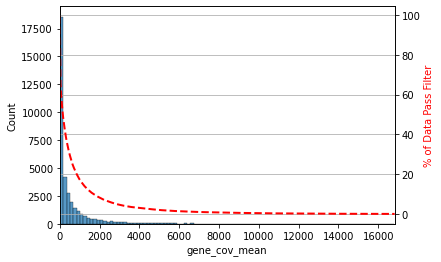

In [67]:
mcds = MCDS.open(mcds_path_list, obs_dim=obs_dim, use_obs=metadata.index).sel({var_dim: use_features})
mcds.add_feature_cov_mean(var_dim=var_dim)

feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index

print(f'{use_features.size} features remained')

In [70]:
mcds.filter_feature_by_cov_mean(var_dim, min_cov=min_cov)

Before cov mean filter: 36443 gene
 After cov mean filter: 31199 gene 85.6%


<xarray.MCDS>
Dimensions:              (cell: 8225, chrom100k: 30895, count_type: 2, gene: 31199, mc_type: 2)
Coordinates: (12/13)
  * mc_type              (mc_type) <U3 'CGN' 'CHN'
  * cell                 (cell) <U34 'M1C_presorted_001_Plate1-1-O7-C2' ... '...
  * gene                 (gene) object 'ENSG00000227232.5' ... 'ENSG000001843...
  * count_type           (count_type) <U3 'mc' 'cov'
    strand_type          <U4 'both'
    gene_chrom           (gene) <U1 dask.array<chunksize=(2423,), meta=np.ndarray>
    ...                   ...
    gene_end             (gene) int64 dask.array<chunksize=(2423,), meta=np.ndarray>
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 30891 30892 30893 30894
    chrom100k_chrom      (chrom100k) <U1 dask.array<chunksize=(4096,), meta=np.ndarray>
    chrom100k_bin_start  (chrom100k) int64 dask.array<chunksize=(4096,), meta=np.ndarray>
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(4096,), meta=np.ndarray>
    gene_cov_mean        (gene) float64 29.81 21.03 6.75 ... 120.3 12.08 315.6
Data variables:
    gene_da              (cell, gene, mc_type, count_type) uint32 dask.array<chunksize=(1645, 2423, 1, 1), meta=np.ndarray>
    chrom100k_da         (cell, chrom100k, mc_type, count_type) uint32 dask.array<chunksize=(1645, 4096, 1, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  null

In [71]:
mcds = mcds.filter_feature_by_cov_mean(var_dim, min_cov=min_cov)

Before cov mean filter: 36443 gene
 After cov mean filter: 31199 gene 85.6%


In [72]:
mcds

<xarray.MCDS>
Dimensions:              (cell: 8225, chrom100k: 30895, count_type: 2, gene: 31199, mc_type: 2)
Coordinates: (12/13)
  * mc_type              (mc_type) <U3 'CGN' 'CHN'
  * cell                 (cell) <U34 'M1C_presorted_001_Plate1-1-O7-C2' ... '...
  * gene                 (gene) object 'ENSG00000227232.5' ... 'ENSG000001843...
  * count_type           (count_type) <U3 'mc' 'cov'
    strand_type          <U4 'both'
    gene_chrom           (gene) <U1 dask.array<chunksize=(2423,), meta=np.ndarray>
    ...                   ...
    gene_end             (gene) int64 dask.array<chunksize=(2423,), meta=np.ndarray>
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 30891 30892 30893 30894
    chrom100k_chrom      (chrom100k) <U1 dask.array<chunksize=(4096,), meta=np.ndarray>
    chrom100k_bin_start  (chrom100k) int64 dask.array<chunksize=(4096,), meta=np.ndarray>
    chrom100k_bin_end    (chrom100k) int64 dask.array<chunksize=(4096,), meta=np.ndarray>
    gene_cov_mean        (gene) float64 29.81 21.03 6.75 ... 120.3 12.08 315.6
Data variables:
    gene_da              (cell, gene, mc_type, count_type) uint32 dask.array<chunksize=(1645, 2423, 1, 1), meta=np.ndarray>
    chrom100k_da         (cell, chrom100k, mc_type, count_type) uint32 dask.array<chunksize=(1645, 4096, 1, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  null

# Calculate and save gene mc fraction

In [73]:
mcds.add_mc_frac(var_dim, normalize_per_cell=True, clip_norm_value=10)

In [74]:
# only keep fraction for saving
mcds = mcds[['gene_da_frac']]
mcds['gene_da_frac'] = mcds['gene_da_frac'].astype('float32')

In [79]:
mcds.write_dataset(f'{indir}gene_frac.mcds', var_dims=['gene'],  mode="w")

/gale/netapp/home2/chl017/software/anaconda3/envs/allcools/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


PosixPath('/gale/netapp/home2/chl017/project/M1C/data/gene_frac.mcds')

In [80]:
use_gene_meta = gene_meta.loc[use_features]
use_gene_meta.to_csv(f'{indir}GeneMetadata.csv.gz')

# Read cell type

In [5]:
cluster_col = 'celltype'

obs_dim = 'cell'
var_dim = 'gene'
mc_type = 'CGN'

top_n = 1000
auroc_cutoff = 0.8
adj_p_cutoff = 0.001
fc_cutoff = 0.8
max_cluster_cells = 2000
max_other_fold = 5
cpu = 10

In [6]:
mcad = anndata.read_h5ad('/gale/netapp/entex/ENTEx/tissue/M1C/matrix/cell_8225_M1C_5kCG_100k3C.h5ad')

In [7]:
mcad.obs['celltype']

cell
M1C_3C_001_Plate1-1-F3-A2               Glia ODC-2
M1C_3C_001_Plate1-1-F3-B1               Glia ODC-2
M1C_3C_001_Plate1-1-F3-B13                     MG1
M1C_3C_001_Plate1-1-F3-B14           Neu IT L2/3-3
M1C_3C_001_Plate1-1-F3-B2            Neu IT L2/3-3
                                         ...      
M1C_presorted_002_Plate8-6-K3-O24      Neu CGE VIP
M1C_presorted_002_Plate8-6-K3-P11    Neu IT L2/3-1
M1C_presorted_002_Plate8-6-K3-P12    Neu IT L2/3-2
M1C_presorted_002_Plate8-6-K3-P23    Neu IT L2/3-1
M1C_presorted_002_Plate8-6-K3-P24        Neu IT L6
Name: celltype, Length: 8225, dtype: category
Categories (29, object): ['Fibro VLMC', 'Glia Astro', 'Glia ODC-1', 'Glia ODC-2', ..., 'Neu MGE SST-2', 'Neu NP', 'Sm Mus', 'VEC']

In [6]:
mcad

AnnData object with n_obs × n_vars = 8225 × 519068
    obs: 'Plate', 'PCRIndex', 'MultiplexGroup', 'RandomIndex', 'Col384', 'Row384', 'R1InputReads', 'R1InputReadsBP', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReads', 'R1TrimmedReadsBP', 'R1TrimmedReadsRate', 'R1UniqueMappedReads', 'R1DeduppedReads', 'R2InputReads', 'R2InputReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReads', 'R2TrimmedReadsBP', 'R2TrimmedReadsRate', 'R2UniqueMappedReads', 'R2DeduppedReads', 'CisShortContact', 'CisLongContact', 'TransContact', 'mCHmC', 'mCHCov', 'mCHFrac', 'mCGmC', 'mCGCov', 'mCGFrac', 'mCCCmC', 'mCCCCov', 'mCCCFrac', 'GenomeCov', 'FinalmCReads', 'CellInputReadPairs', 'R1MappingRate', 'R2MappingRate', 'R1DuplicationRate', 'R2DuplicationRate', 'CellBarcodeRatio', 'TotalContacts', 'CisShortRatio', 'CisLongRatio', 'TransRatio', 'Tissue', 'Sample', 'Protocol', 'Donor', 'Nuclei', 'Cis/Trans', 'tsne_0', 'tsne_1', 'Cluster', 'leiden', '5kCG100k3C_u35u20_leiden_0.5', '5kCG100k3C_u35u20_leiden_0.8', 

# Calculate DMG

In [8]:
gf_mcds_path = f'{indir}gene_frac.mcds'

In [8]:
dmg_table = one_vs_rest_dmg(mcad.obs,
                            group=cluster_col,
                            mcds_paths=gf_mcds_path,
                            obs_dim=obs_dim,
                            var_dim=var_dim,
                            mc_type=mc_type,
                            top_n=top_n,
                            adj_p_cutoff=adj_p_cutoff,
                            fc_cutoff=fc_cutoff,
                            auroc_cutoff=auroc_cutoff,
                            max_cluster_cells=max_cluster_cells,
                            max_other_fold=max_other_fold,
                            cpu=cpu)

Calculating cluster Fibro VLMC DMGs.
Calculating cluster Glia Astro DMGs.
Calculating cluster Glia ODC-1 DMGs.
Calculating cluster Glia ODC-2 DMGs.
Calculating cluster Glia ODC-3 DMGs.
Calculating cluster Glia OPC DMGs.
Calculating cluster MG1 DMGs.
Calculating cluster MG2 DMGs.
Calculating cluster Neu CGE LAMP5 DMGs.
Calculating cluster Neu CGE SNCG DMGs.
Calculating cluster Neu CGE VIP DMGs.
Glia ODC-3 Finished.
Calculating cluster Neu CLA DMGs.
Fibro VLMC Finished.
Calculating cluster Neu CT L6 DMGs.
MG2 Finished.
Calculating cluster Neu ET L5 DMGs.
Neu CGE LAMP5 Finished.
Calculating cluster Neu IT L2/3-1 DMGs.
Glia OPC Finished.
Calculating cluster Neu IT L2/3-2 DMGs.
Neu CT L6 Finished.
Calculating cluster Neu IT L2/3-3 DMGs.
Neu CLA Finished.
Calculating cluster Neu IT L2/3-4 DMGs.
Neu ET L5 Finished.
Calculating cluster Neu IT L4 DMGs.
MG1 Finished.
Calculating cluster Neu IT L5 DMGs.
Neu CGE SNCG Finished.
Calculating cluster Neu IT L6 DMGs.
Neu CGE VIP Finished.
Calculating c

In [9]:
dmg_table.to_hdf(f'{indir + cluster_col}.OneVsRestDMG.hdf', key='data')

# Plot Cluster DMGs

In [9]:
downsample = 30000
coord_base = 'tsne'
cluster_dmg_path = f'{indir + cluster_col}.OneVsRestDMG.hdf'

In [10]:
use_cells = mcad.obs_names

In [11]:
cluster_dmgs = pd.read_hdf(cluster_dmg_path)
cluster_dmgs.head()

pvals_adj        fc     AUROC     cluster
names                                                           
ENSG00000100142.15  1.163760e-12  0.536644  0.855471  Glia ODC-3
ENSG00000136541.14  1.163760e-12  0.546318  0.854083  Glia ODC-3
ENSG00000150656.15  3.172460e-12  0.795404  0.844562  Glia ODC-3
ENSG00000197971.15  5.189991e-12  0.722777  0.839603  Glia ODC-3
ENSG00000102934.10  7.829241e-12  0.568305  0.836959  Glia ODC-3

In [12]:
gene_meta = pd.read_csv(f'{indir}GeneMetadata.csv.gz', index_col=0)
gene_name_to_gene_id = {v: k for k, v in gene_meta['gene_name'].items()}
gene_meta.index.name = 'gene_id'

gene_frac_da = MCDS.open(gf_mcds_path,
                         use_obs=use_cells)[f'gene_da_frac']
gene_frac_da = gene_frac_da.sel(mc_type=mc_type).load()
gene_frac_da

<xarray.DataArray 'gene_da_frac' (cell: 8225, gene: 31199)>
array([[1.        , 1.        , 1.        , ..., 1.157118  , 1.        ,
        0.11361171],
       [1.        , 1.        , 1.1454    , ..., 1.        , 1.        ,
        1.1454    ],
       [1.2660195 , 1.        , 1.        , ..., 1.2660195 , 1.        ,
        1.091126  ],
       ...,
       [1.1164919 , 1.1164919 , 1.        , ..., 1.1130025 , 0.61292493,
        0.8841467 ],
       [1.2081567 , 1.2136743 , 1.        , ..., 1.2081567 , 1.        ,
        0.35324946],
       [1.1988026 , 1.        , 1.1353562 , ..., 1.3294835 , 1.        ,
        0.9575971 ]], dtype=float32)
Coordinates:
  * cell           (cell) <U34 'M1C_presorted_001_Plate1-1-O7-C2' ... 'M1C_3C...
  * gene           (gene) <U18 'ENSG00000227232.5' ... 'ENSG00000184319.16'
    gene_chrom     (gene) <U5 'chr1' 'chr1' 'chr1' ... 'chr22' 'chr22' 'chr22'
    gene_cov_mean  (gene) float64 29.81 21.03 6.75 100.9 ... 120.3 12.08 315.6
    gene_end       (gene) int64 29570 64116 71585 ... 50745334 50755434 50801309
    gene_start     (gene) int64 14403 57597 65418 ... 50738195 50754674 50756947
    mc_type        <U3 'CGN'
    strand_type    <U4 'both'

In [13]:
def get_gene_values_by_name(gene_name):
    data = gene_frac_da.sel(gene=gene_name_to_gene_id[gene_name]).to_pandas()
    data.name = gene_name
    return data

In [14]:
def plot_cluster_and_genes(cluster, cell_meta, cluster_col, genes_data,
                           coord_base='tsne', ncols=5, axes_size=3, dpi=150, hue_norm=(0.67, 1.5)):
    ncols = max(2, ncols)
    nrows = 1 + (genes_data.shape[1] - 1) // ncols + 1

    # figure
    fig = plt.figure(figsize=(ncols * axes_size, nrows * axes_size), dpi=dpi)
    gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

    # cluster axes
    ax = fig.add_subplot(gs[0, 0])
    categorical_scatter(data=cell_meta,
                        ax=ax,
                        coord_base=coord_base,
                        axis_format=None,
                        hue=cluster_col,
                        palette='tab20')
    ax.set_title('All Clusters')
    ax = fig.add_subplot(gs[0, 1])
    categorical_scatter(data=cell_meta,
                        ax=ax,
                        coord_base=coord_base,
                        hue=cell_meta[cluster_col] == cluster,
                        axis_format=None,
                        palette={
                            True: 'red',
                            False: 'lightgray'
                        })
    ax.set_title('This Cluster')

    # gene axes
    for i, (gene, data) in enumerate(genes_data.iteritems()):
        col = i % ncols
        row = i // ncols + 1
        ax = fig.add_subplot(gs[row, col])

        if ax.get_subplotspec().is_first_col() and ax.get_subplotspec().is_last_row():
            axis = 'tiny'
        else:
            axis = None

        continuous_scatter(ax=ax,
                           data=cell_meta,
                           hue=data,
                           axis_format=axis,
                           hue_norm=hue_norm,
                           coord_base=coord_base)
        ax.set_title(f'{data.name}')
    fig.suptitle(f'Cluster {cluster} Top Markers')
    return fig

/gale/netapp/home2/chl017/software/anaconda3/envs/allcools/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


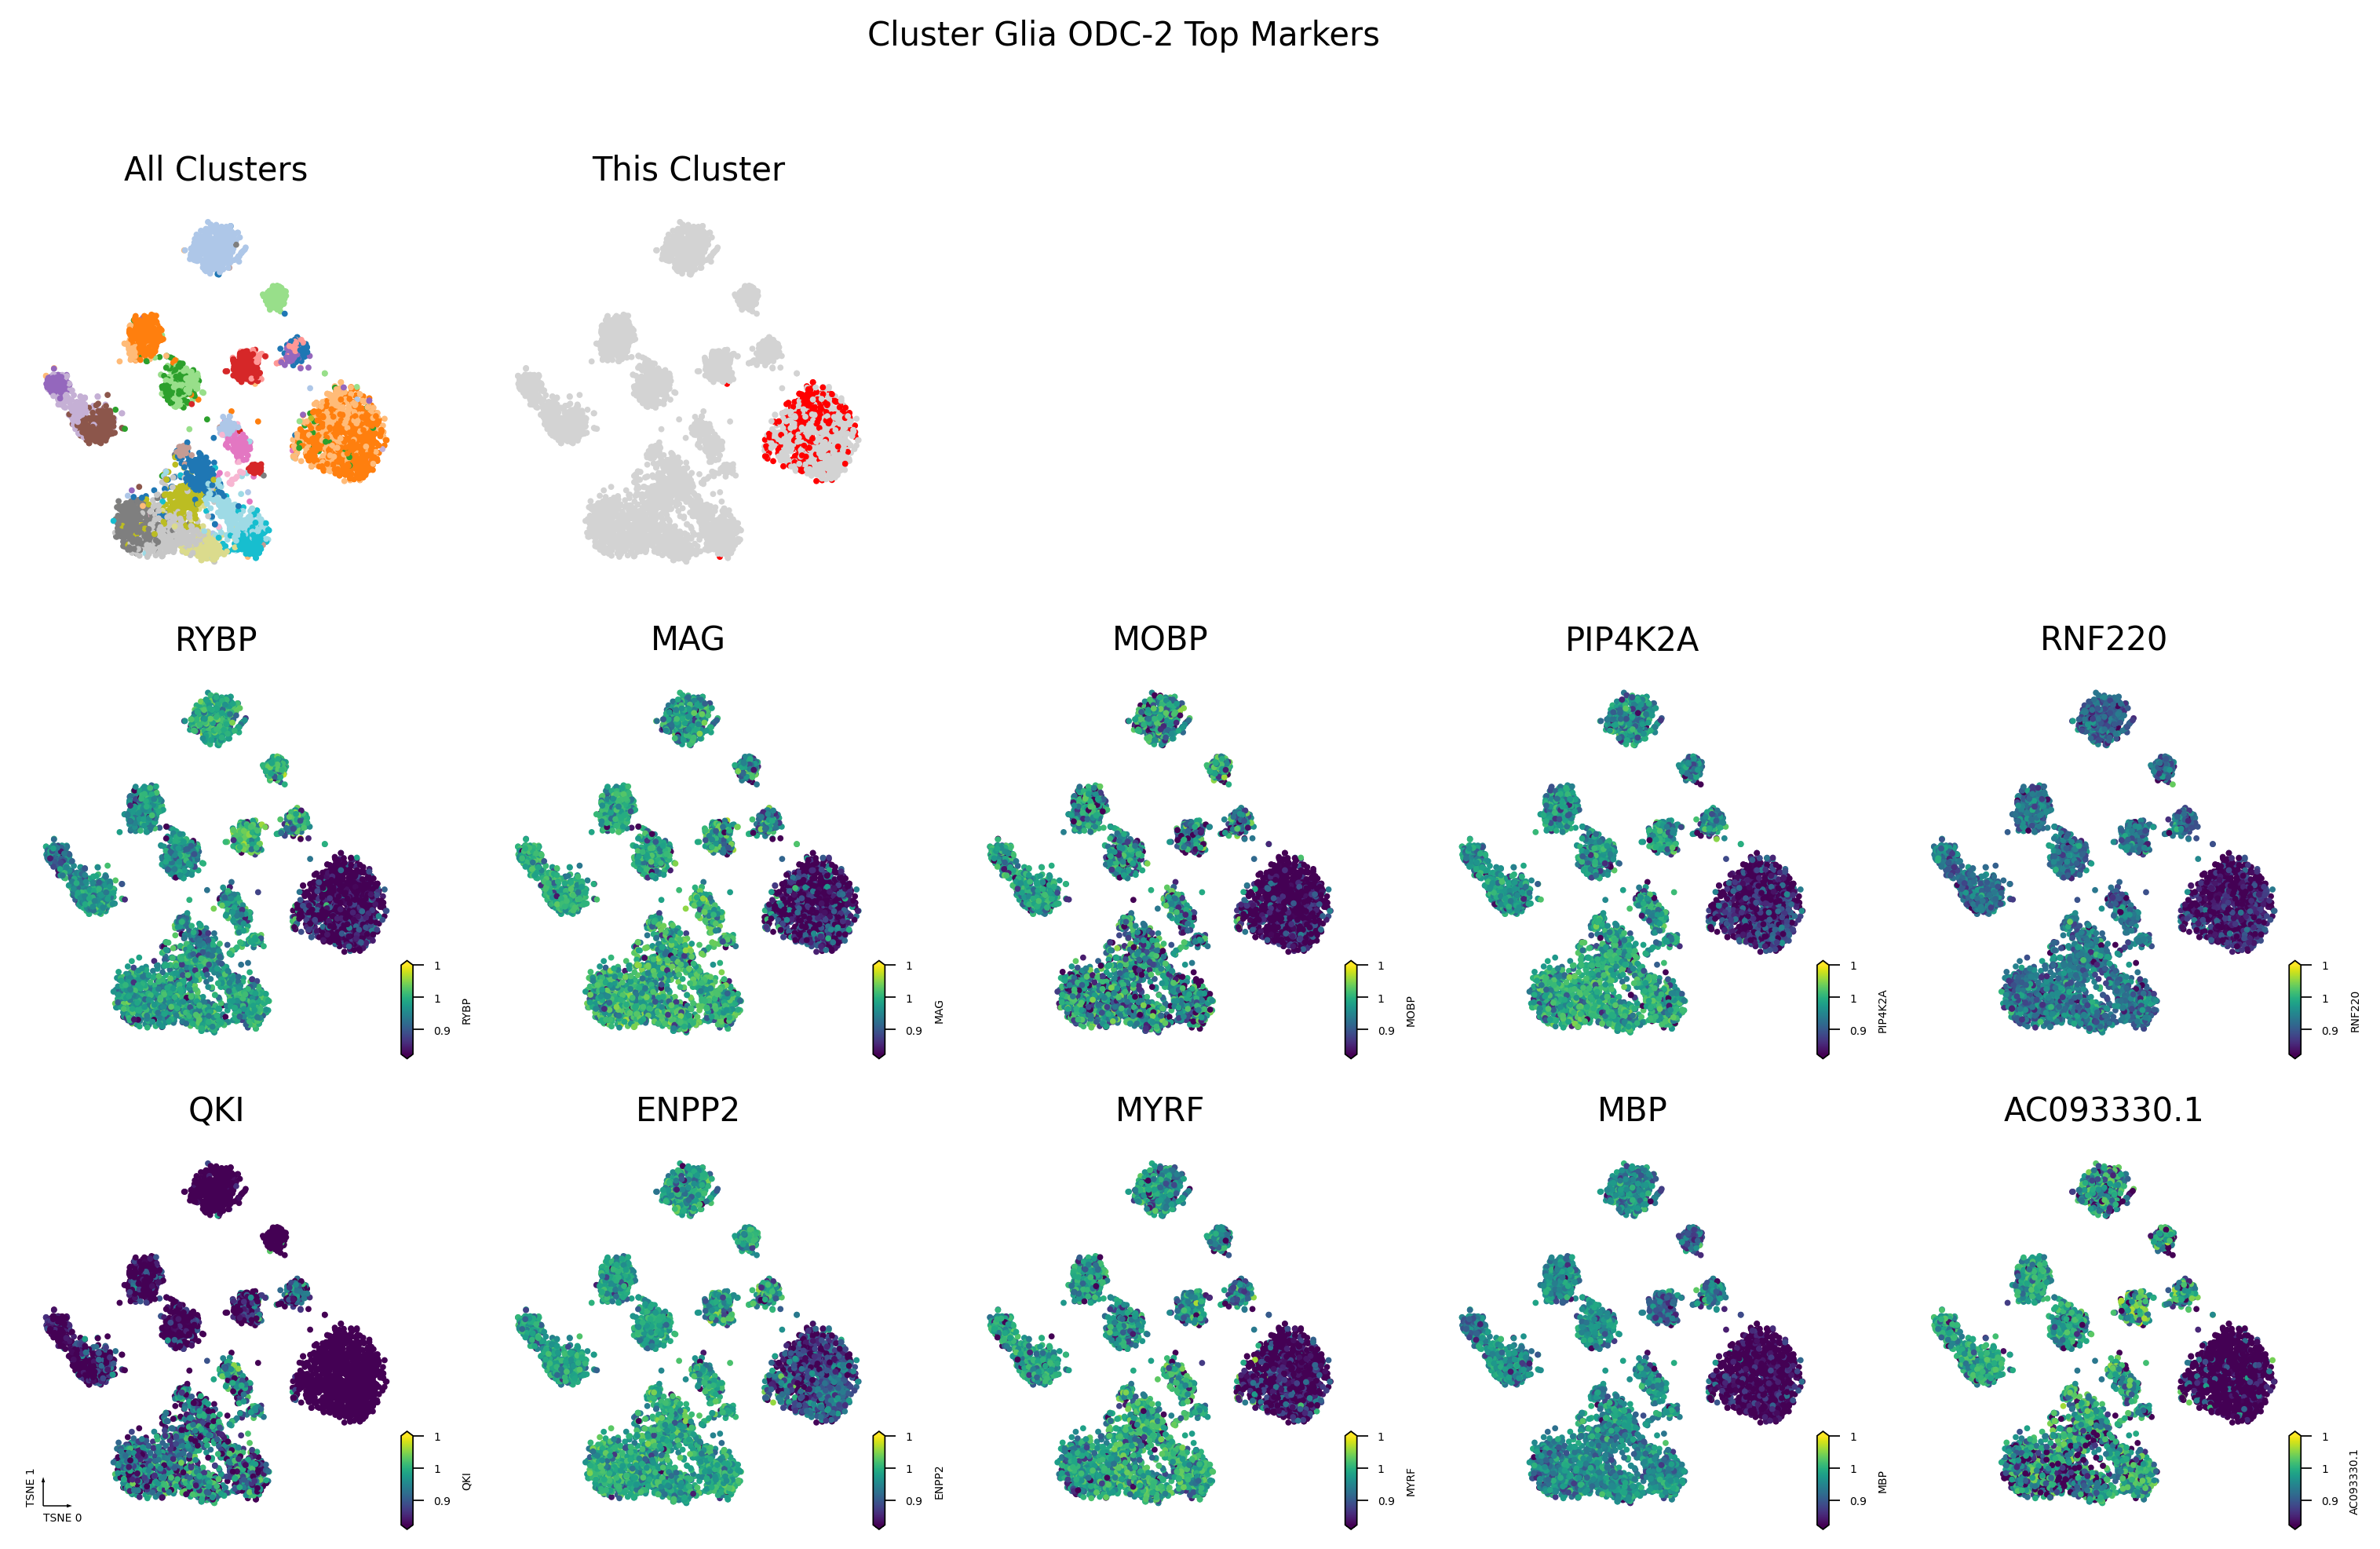

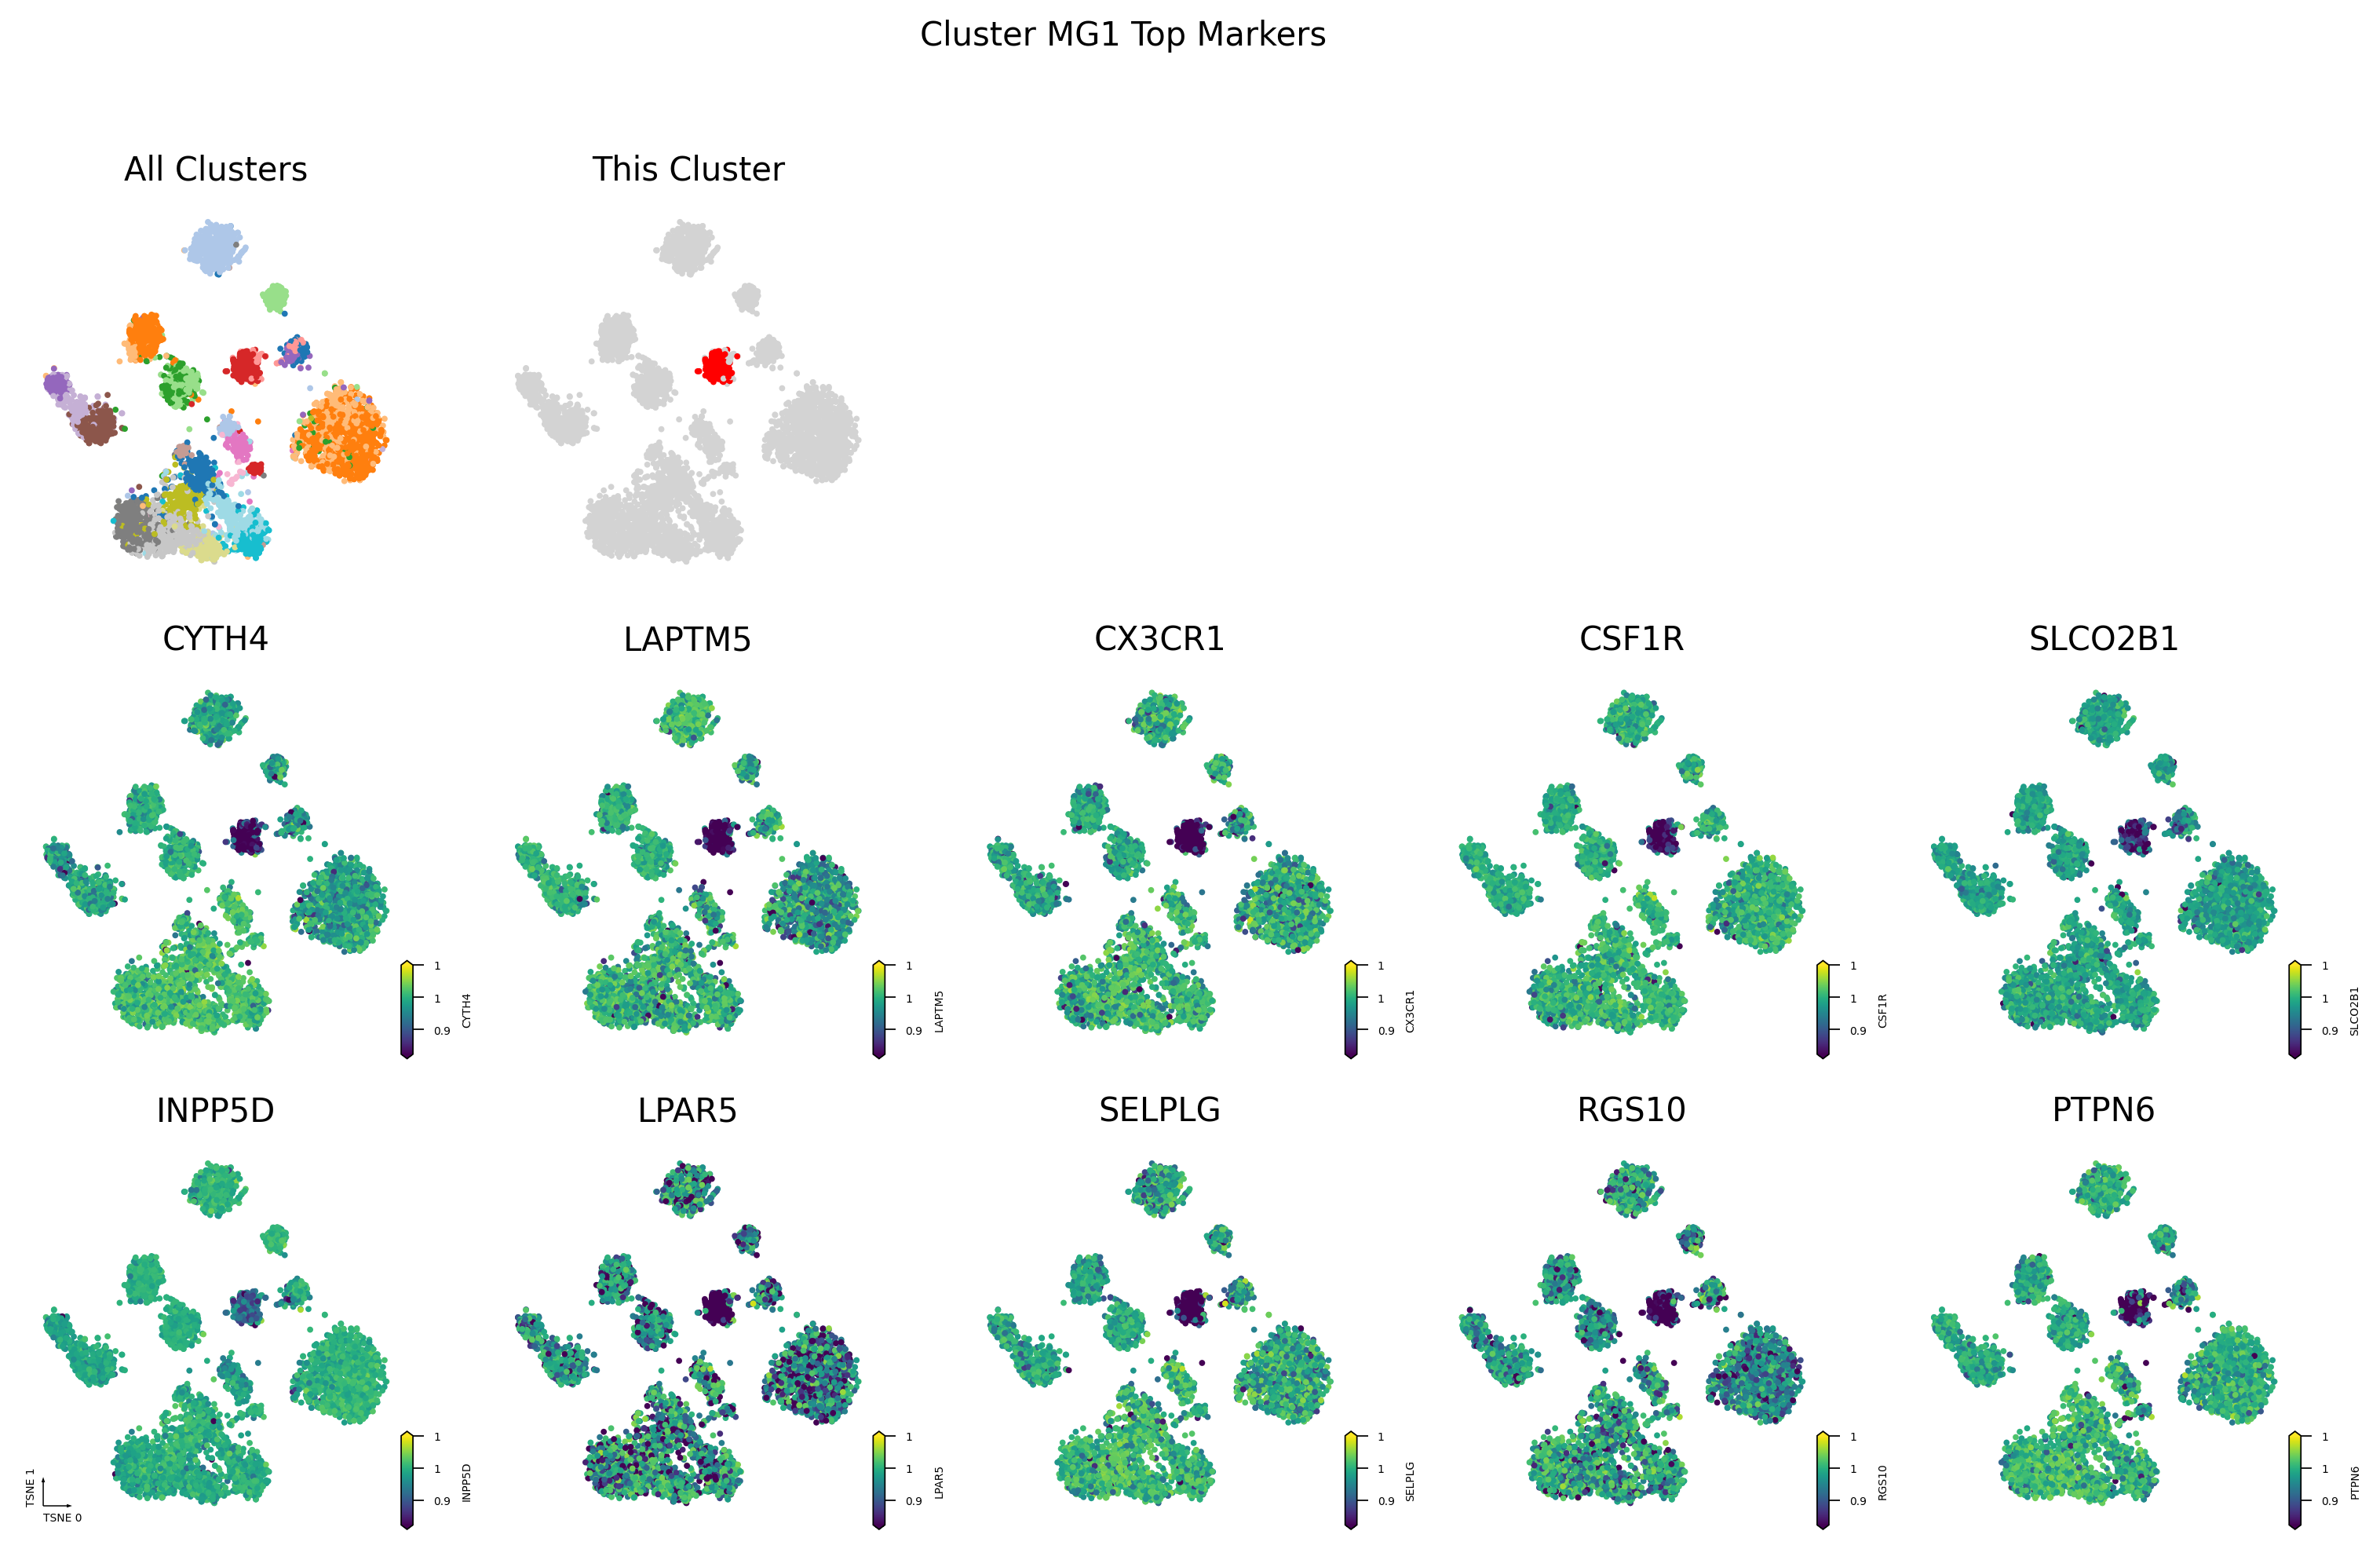

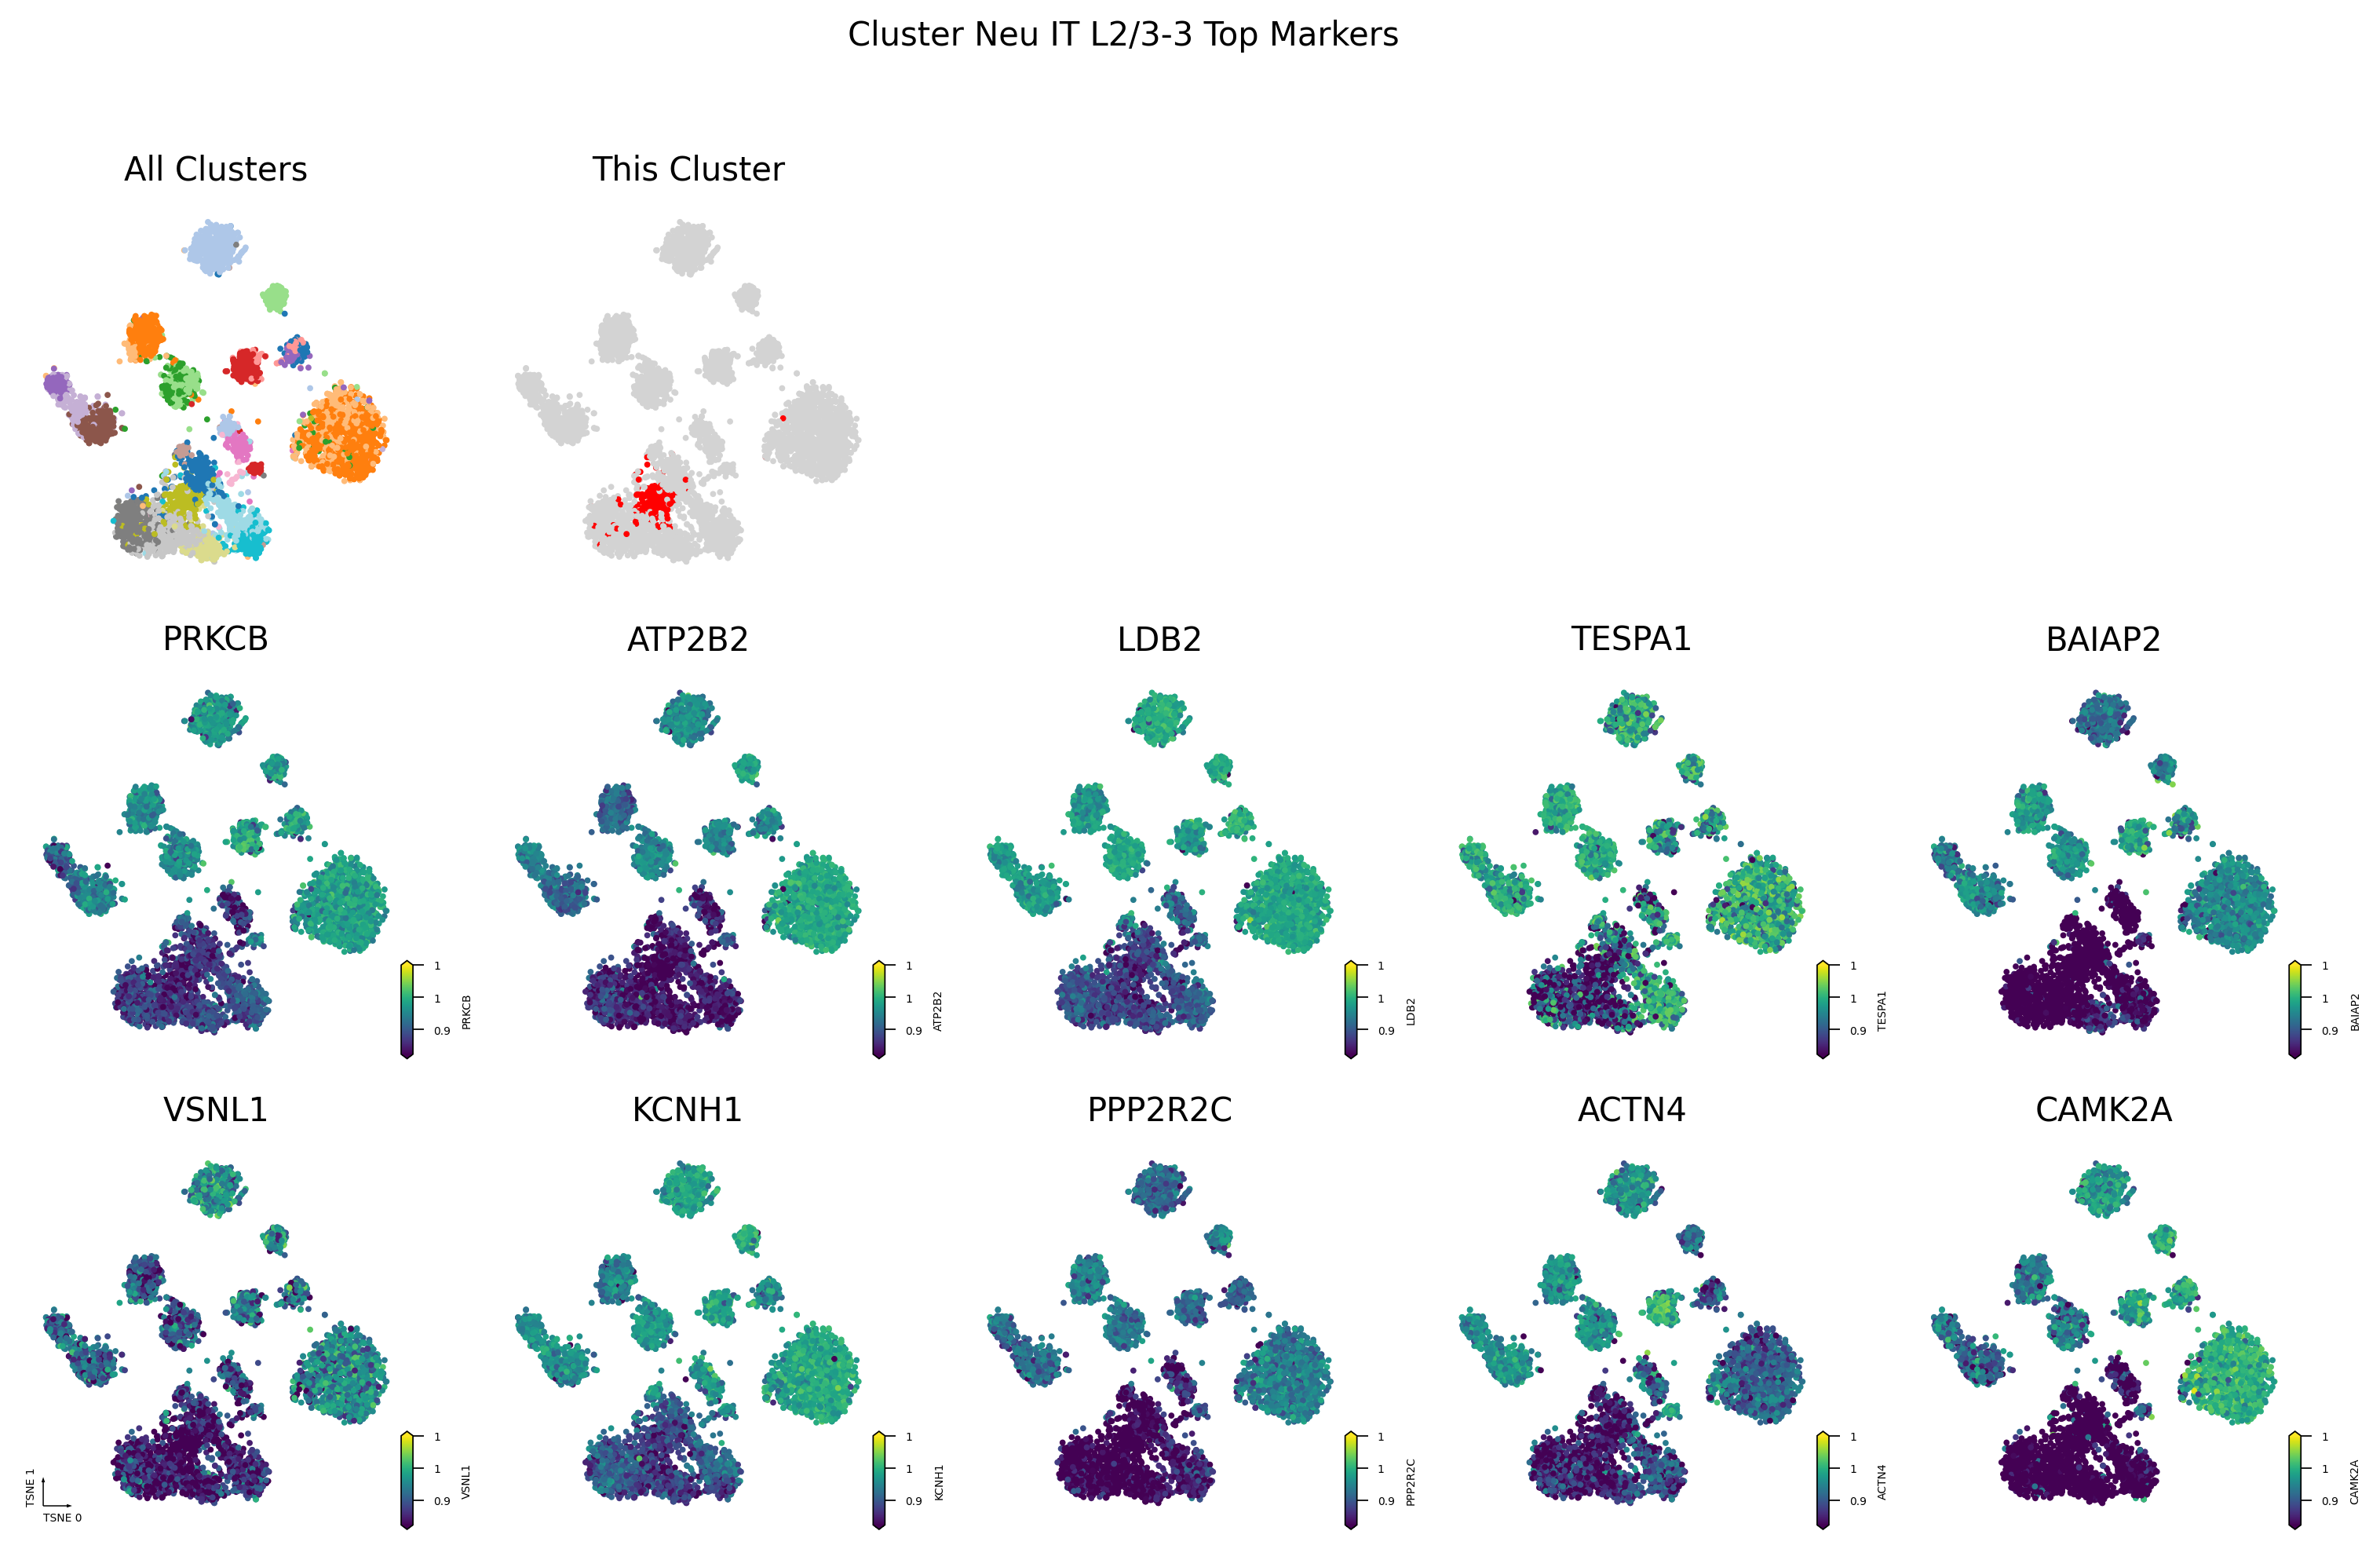

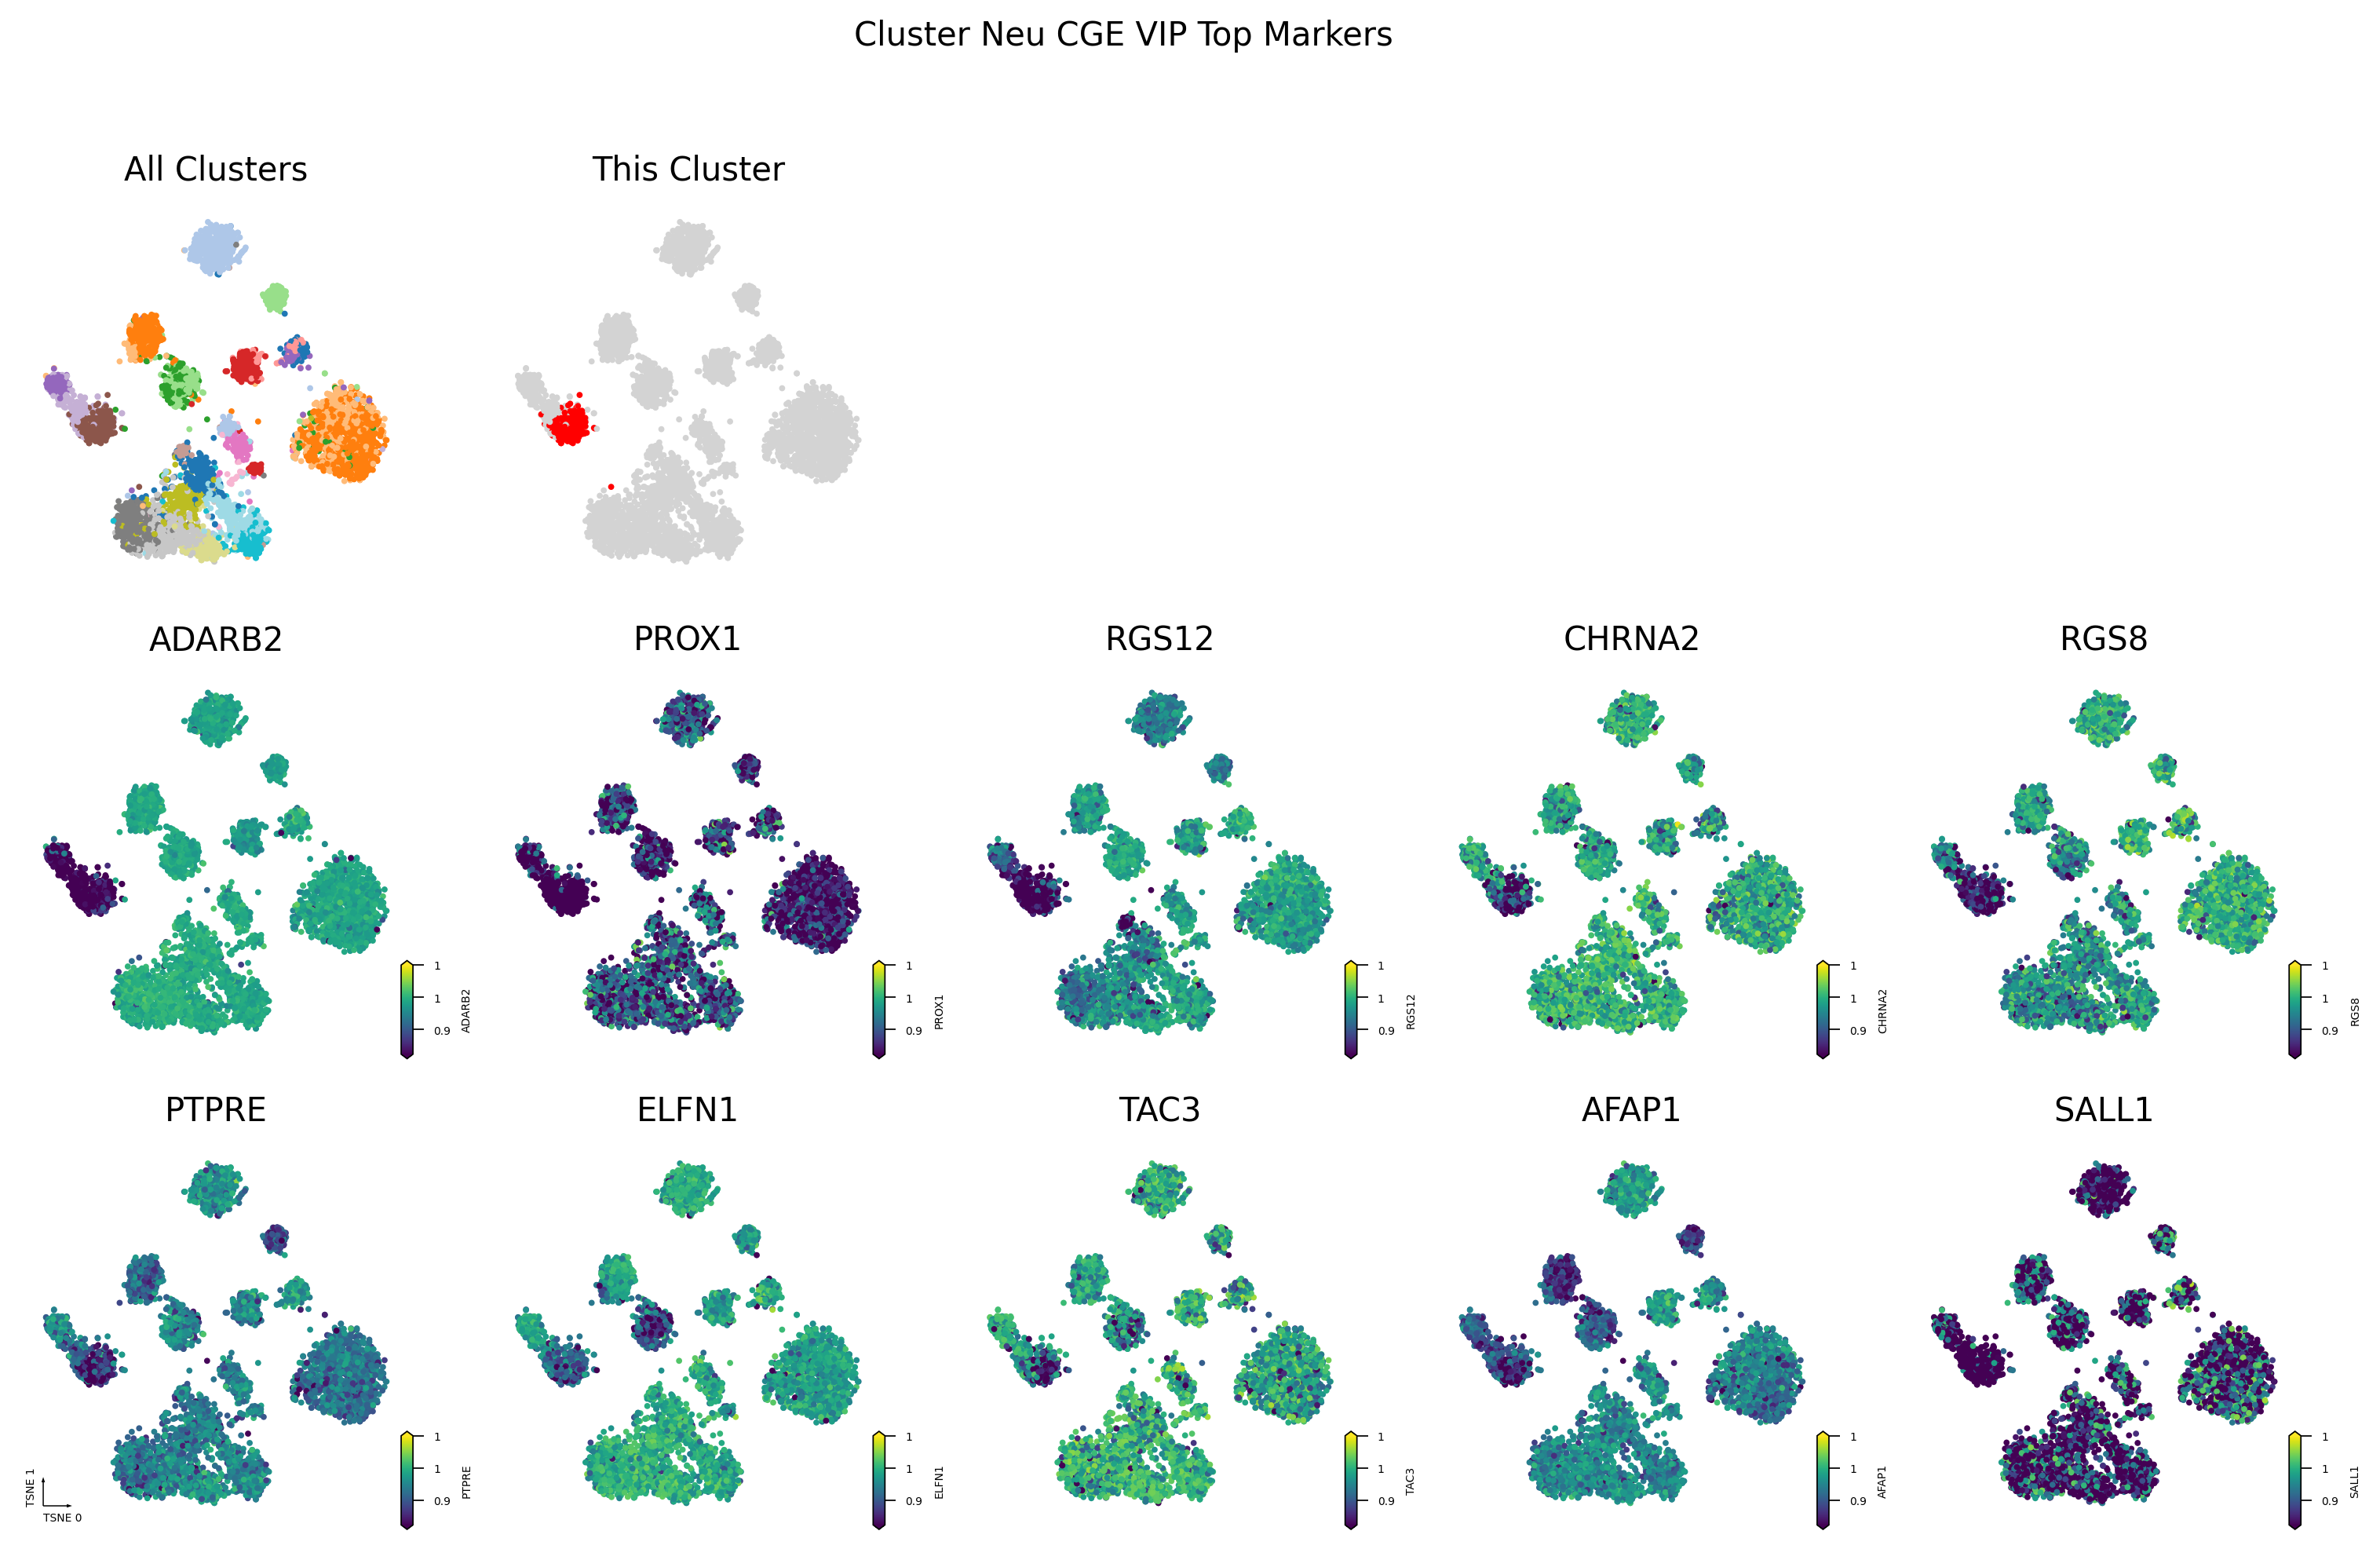

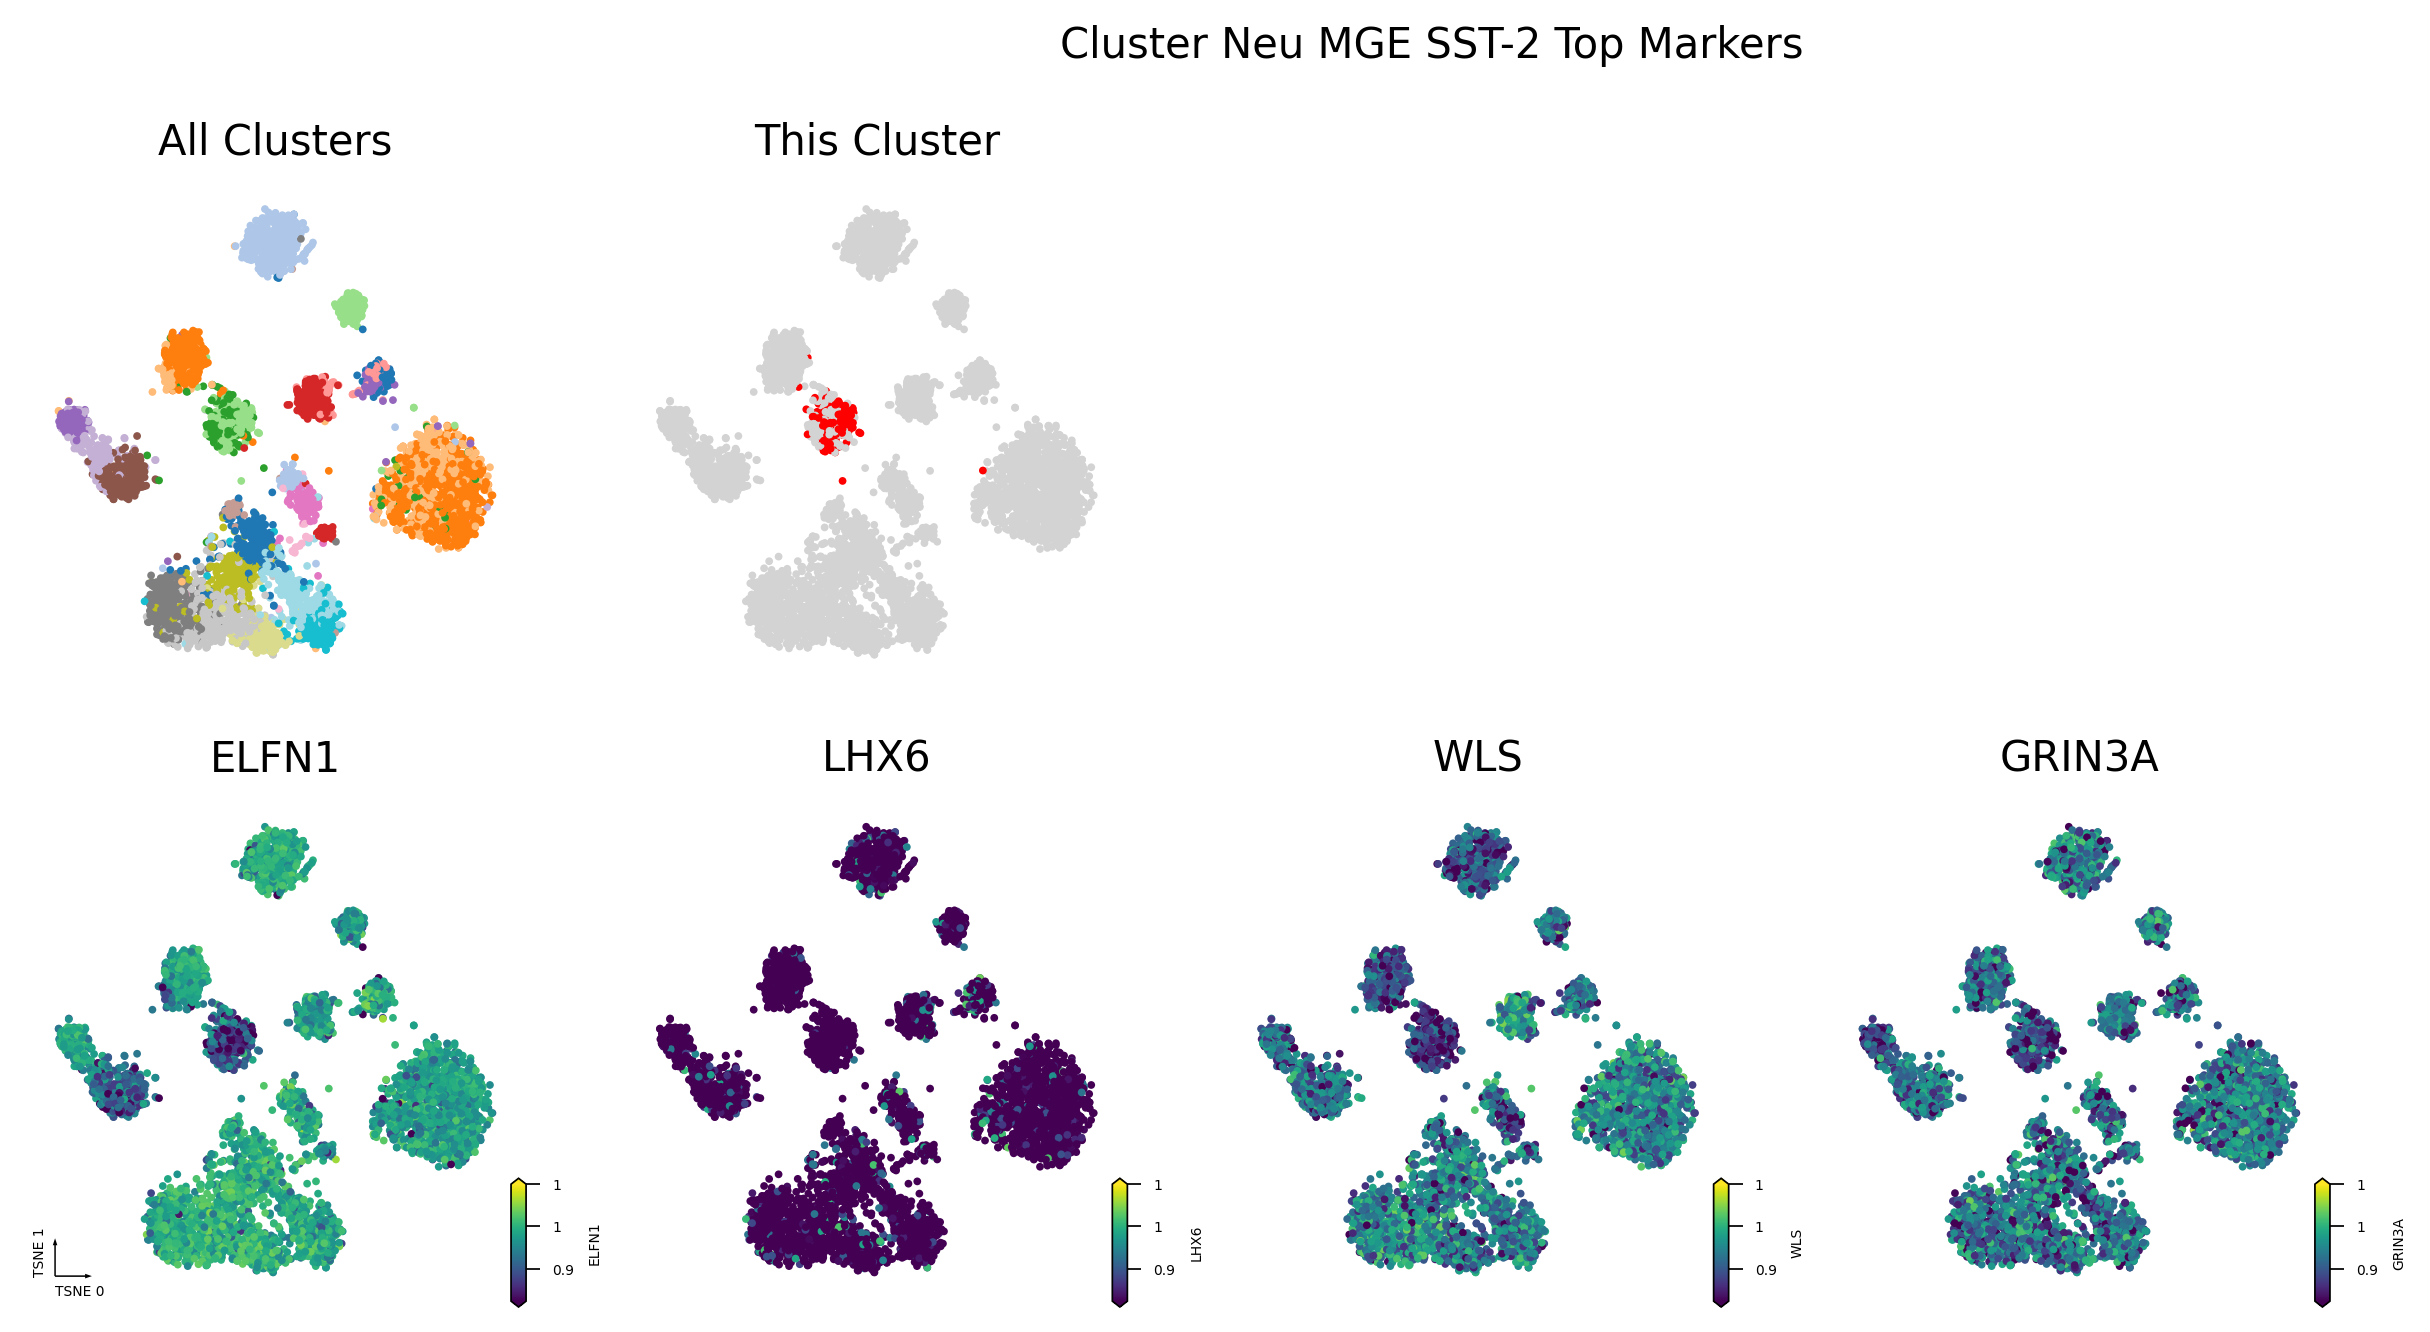

In [ ]:
for cluster in mcad.obs['celltype'].unique():
    genes = cluster_dmgs[cluster_dmgs['cluster'] == cluster].sort_values('AUROC', ascending=False)[:10]
    genes_data = gene_frac_da.sel(gene=genes.index).to_pandas()
    genes_data.columns = genes_data.columns.map(gene_meta['gene_name'])

    fig = plot_cluster_and_genes(cluster=cluster,
                                 cell_meta=mcad.obs,
                                 cluster_col=cluster_col,
                                 genes_data=genes_data,
                                 coord_base='tsne',
                                 ncols=5,
                                 axes_size=3,
                                 dpi=250)
                                 #hue_norm=(0.67, 1.5))
        
    cluster = cluster.replace(' ', '_').replace('/', '_')
    fig.savefig(f'{cluster}.TopMarker.png', bbox_inches='tight')

# Test and present for single gene

In [ ]:
import scipy.stats as stats
import scikit_posthocs as sp

In [ ]:
mcad.obs

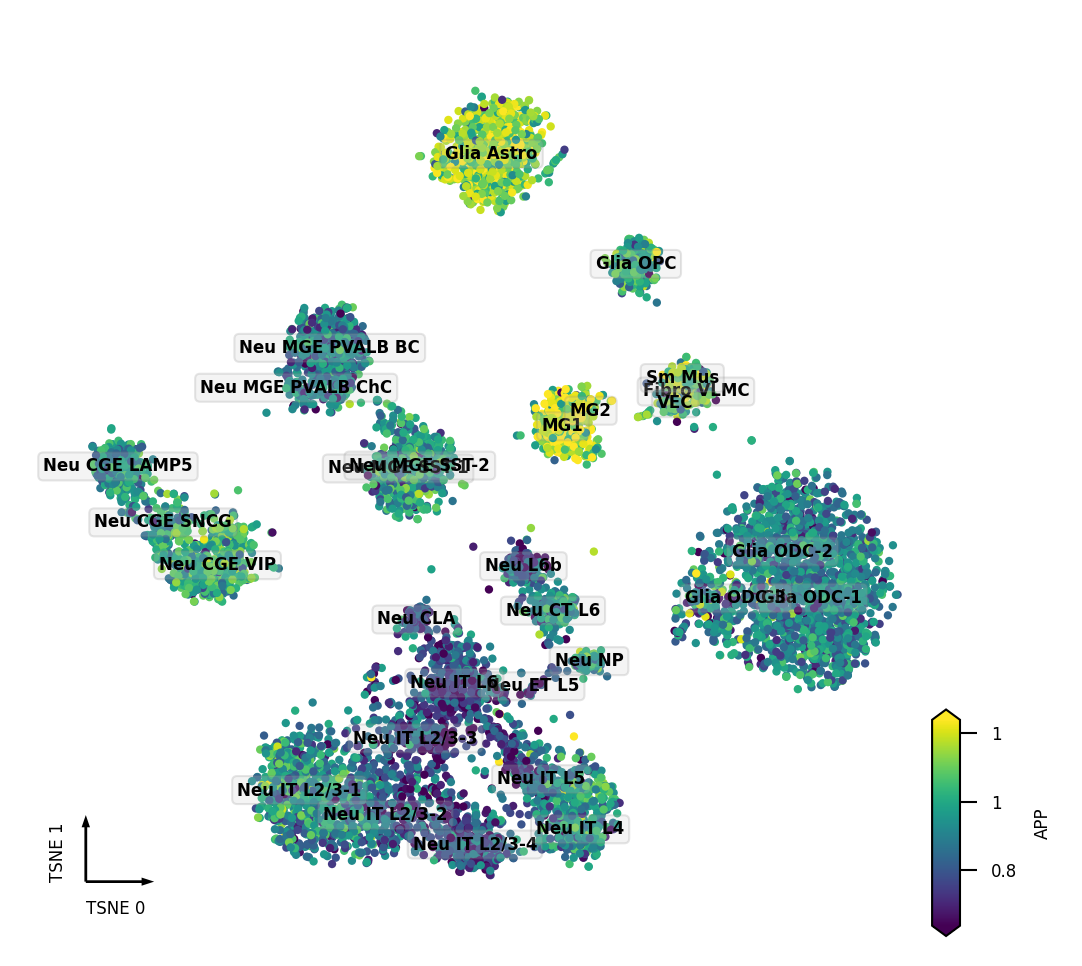

In [98]:
gene = 'APP'
hue_norm = (0.67, 1.5)
coord_base = 'tsne'

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

_ = continuous_scatter(ax=ax,
                       data=mcad.obs,
                       hue=get_gene_values_by_name(gene),
#                       hue_norm=hue_norm,
                       text_anno=cluster_col,
                       coord_base=coord_base,
                       max_points=None,
                       s=4)

In [99]:
for_calc = pd.concat([mcad.obs, get_gene_values_by_name(gene)], axis=1)[[gene, "celltype"]]

In [100]:
for_calc

APP       celltype
cell                                                      
M1C_3C_001_Plate1-1-F3-A2          0.692954     Glia ODC-2
M1C_3C_001_Plate1-1-F3-B1          0.649321     Glia ODC-2
M1C_3C_001_Plate1-1-F3-B13         1.222932            MG1
M1C_3C_001_Plate1-1-F3-B14         0.700069  Neu IT L2/3-3
M1C_3C_001_Plate1-1-F3-B2          1.014481  Neu IT L2/3-3
...                                     ...            ...
M1C_presorted_002_Plate8-6-K3-O24  1.089689    Neu CGE VIP
M1C_presorted_002_Plate8-6-K3-P11  1.078465  Neu IT L2/3-1
M1C_presorted_002_Plate8-6-K3-P12  0.846185  Neu IT L2/3-2
M1C_presorted_002_Plate8-6-K3-P23  0.888031  Neu IT L2/3-1
M1C_presorted_002_Plate8-6-K3-P24  0.826196      Neu IT L6

[8225 rows x 2 columns]

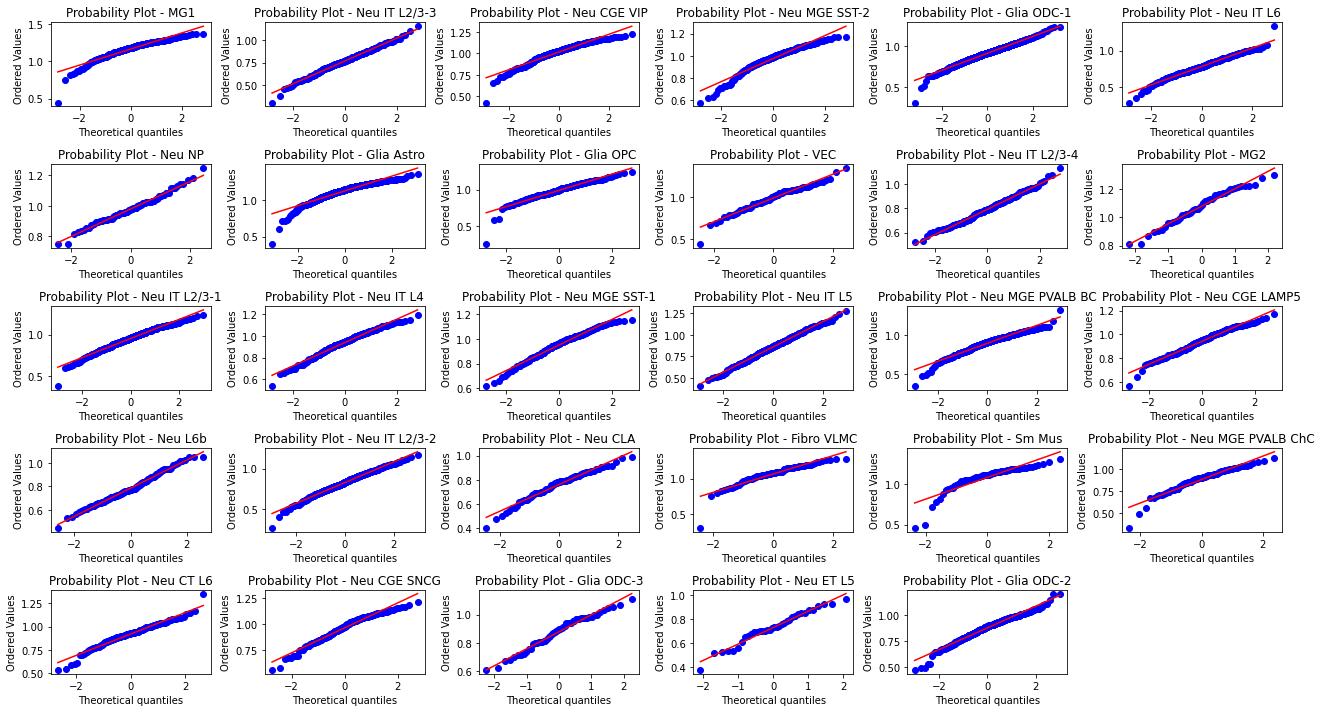

In [101]:
unique_celltype = for_calc['celltype'].unique()
fig, axes = plt.subplots(5, 6, figsize=(18, 10))
fig.delaxes(axes[4, 5])
for celltype, ax in zip(unique_celltype, axes.flatten()[:-1]):
    stats.probplot(for_calc[for_calc['celltype'] == celltype][gene], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  celltype)
    plt.axes(ax)
    
fig.tight_layout()

In [102]:
for_calc['log'] = np.log(for_calc[gene])

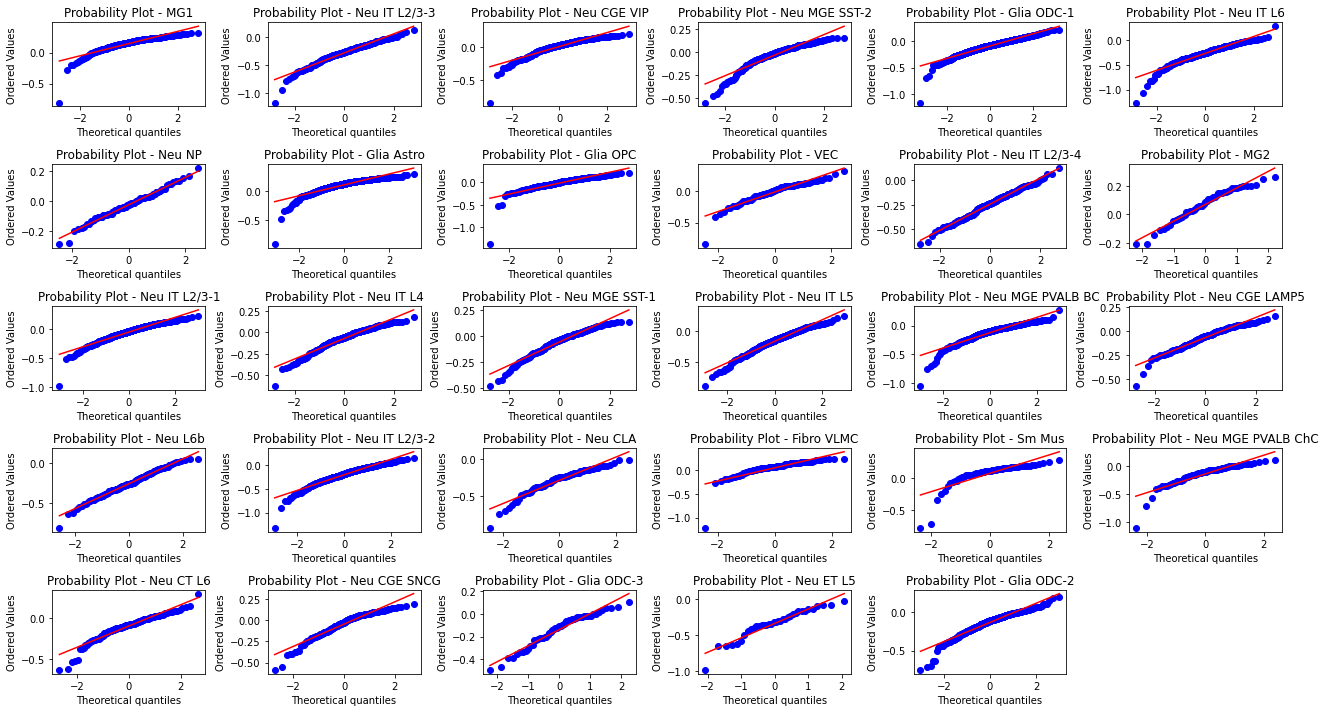

In [103]:
fig, axes = plt.subplots(5, 6, figsize=(18, 10))
fig.delaxes(axes[4, 5])
for celltype, ax in zip(unique_celltype, axes.flatten()[:-1]):
    stats.probplot(for_calc[for_calc['celltype'] == celltype]['log'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  celltype)
    plt.axes(ax)
    
fig.tight_layout()

In [104]:
for_calc.groupby('celltype').std()


APP       log
celltype                             
Fibro VLMC         0.139021  0.173321
Glia Astro         0.105032  0.104319
Glia ODC-1         0.102709  0.118811
Glia ODC-2         0.105038  0.126547
Glia ODC-3         0.118651  0.140832
Glia OPC           0.114646  0.141141
MG1                0.111406  0.108252
MG2                0.120680  0.115636
Neu CGE LAMP5      0.096874  0.107081
Neu CGE SNCG       0.121034  0.133868
Neu CGE VIP        0.104976  0.112790
Neu CLA            0.110748  0.158513
Neu CT L6          0.116060  0.134183
Neu ET L5          0.134037  0.201591
Neu IT L2/3-1      0.115075  0.128938
Neu IT L2/3-2      0.128336  0.168456
Neu IT L2/3-3      0.125353  0.174378
Neu IT L2/3-4      0.104112  0.132842
Neu IT L4          0.107906  0.120878
Neu IT L5          0.144840  0.176925
Neu IT L6          0.127701  0.177185
Neu L6b            0.118727  0.154448
Neu MGE PVALB BC   0.114249  0.139964
Neu MGE PVALB ChC  0.134981  0.183205
Neu MGE SST-1      0.104376  0.114819
Neu MGE SST-2      0.106230  0.117388
Neu NP             0.088886  0.091102
Sm Mus             0.149821  0.174234
VEC                0.144112  0.160738

In [105]:
stats.levene(*[d[gene].tolist() for _, d in for_calc.groupby(['celltype'])], center='median')

LeveneResult(statistic=5.900184733499541, pvalue=3.79959689277687e-21)

In [106]:
#result = stats.kruskal(*[d[gene].tolist() for _, d in for_calc.groupby(['celltype'])])
result = stats.f_oneway(*[d[gene].tolist() for _, d in for_calc.groupby(['celltype'])])

In [107]:
result

F_onewayResult(statistic=245.64515323160902, pvalue=0.0)

In [90]:
for_calc.groupby(['celltype']).median()
#for_calc.groupby(['celltype']).mean()

APP       log
celltype                             
Fibro VLMC         1.080870  0.077766
Glia Astro         1.141024  0.131926
Glia ODC-1         0.917937 -0.085626
Glia ODC-2         0.892948 -0.113227
Glia ODC-3         0.895534 -0.110335
Glia OPC           0.996727 -0.003279
MG1                1.178058  0.163867
MG2                1.086183  0.082670
Neu CGE LAMP5      0.949664 -0.051647
Neu CGE SNCG       0.976211 -0.024081
Neu CGE VIP        1.029484  0.029058
Neu CLA            0.783599 -0.243858
Neu CT L6          0.926883 -0.075927
Neu ET L5          0.727091 -0.318723
Neu IT L2/3-1      0.961504 -0.039256
Neu IT L2/3-2      0.829475 -0.186963
Neu IT L2/3-3      0.765824 -0.266804
Neu IT L2/3-4      0.789159 -0.236787
Neu IT L4          0.944370 -0.057238
Neu IT L5          0.865095 -0.144916
Neu IT L6          0.775800 -0.253860
Neu L6b            0.772208 -0.258502
Neu MGE PVALB BC   0.907426 -0.097143
Neu MGE PVALB ChC  0.899608 -0.105797
Neu MGE SST-1      0.963604 -0.037075
Neu MGE SST-2      0.989481 -0.010575
Neu NP             0.977196 -0.023069
Sm Mus             1.114187  0.108125
VEC                1.008887  0.008848

In [108]:
dun_result = sp.posthoc_dunn(for_calc, val_col = gene, group_col = "celltype", p_adjust = "fdr_bh")

In [109]:
corr_dun = dun_result.where(~np.tril(np.ones(dun_result.shape)).astype(np.bool))
corr_dun = corr_dun.stack()

corr_dun.name = 'Dunn’s Test Result'
corr_dun.index.names = ['Celltype1', 'Celltype2']

dun = corr_dun[corr_dun < 0.05].to_frame()

/gale/netapp/home2/chl017/software/anaconda3/envs/allcools/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [110]:
dun_result

Fibro VLMC     Glia Astro     Glia ODC-1     Glia ODC-2  \
Fibro VLMC         1.000000e+00   7.651132e-03   4.498392e-22   2.355190e-30   
Glia Astro         7.651132e-03   1.000000e+00  9.344296e-171  1.145350e-169   
Glia ODC-1         4.498392e-22  9.344296e-171   1.000000e+00   5.206293e-06   
Glia ODC-2         2.355190e-30  1.145350e-169   5.206293e-06   1.000000e+00   
Glia ODC-3         1.961139e-13   1.047078e-28   1.451757e-01   8.214943e-01   
Glia OPC           1.485655e-04   8.030584e-25   4.629539e-16   3.148161e-26   
MG1                2.888890e-04   5.553675e-02  6.195926e-122  2.523612e-133   
MG2                9.354905e-01   5.965989e-02   3.596071e-13   2.181371e-18   
Neu CGE LAMP5      1.478171e-11   4.869895e-50   4.161936e-03   1.134089e-08   
Neu CGE SNCG       6.154157e-08   4.851628e-37   3.433724e-07   7.927642e-15   
Neu CGE VIP        1.852767e-02   4.319152e-20   7.759716e-40   2.870855e-53   
Neu CLA            1.320652e-43  9.791359e-103   1.041767e-19   9.069005e-11   
Neu CT L6          1.575697e-14   6.785838e-54   4.338312e-01   3.789455e-04   
Neu ET L5          2.089371e-26   1.686908e-44   9.270350e-10   4.239777e-06   
Neu IT L2/3-1      2.662317e-11   3.873636e-76   1.785289e-08   7.680125e-19   
Neu IT L2/3-2      1.557800e-44  1.641672e-221   4.897878e-23   1.860419e-06   
Neu IT L2/3-3      4.689651e-58  8.569036e-218   2.786338e-39   6.385472e-18   
Neu IT L2/3-4      1.873389e-52  2.799975e-188   1.356046e-30   1.941018e-13   
Neu IT L4          1.909475e-12   1.664671e-58   3.867969e-03   3.558533e-09   
Neu IT L5          8.350488e-32  3.135893e-154   1.740694e-07   3.417535e-01   
Neu IT L6          8.109270e-57  9.218456e-234   3.149986e-39   1.596500e-16   
Neu L6b            5.384731e-44  4.681701e-123   1.041172e-19   2.147435e-09   
Neu MGE PVALB BC   6.182968e-25  1.321454e-132   2.143052e-02   9.067232e-02   
Neu MGE PVALB ChC  8.829803e-16   1.492128e-38   1.244698e-01   6.356823e-01   
Neu MGE SST-1      1.194487e-09   2.560557e-43   6.562346e-05   1.443914e-11   
Neu MGE SST-2      3.560901e-06   1.734216e-33   1.060710e-12   1.789423e-22   
Neu NP             1.351647e-04   1.892165e-15   4.239777e-06   3.163827e-11   
Sm Mus             4.135080e-01   1.859297e-01   7.908341e-23   1.458165e-30   
VEC                1.020650e-03   5.461958e-13   1.178673e-07   2.936013e-13   

                     Glia ODC-3      Glia OPC            MG1           MG2  \
Fibro VLMC         1.961139e-13  1.485655e-04   2.888890e-04  9.354905e-01   
Glia Astro         1.047078e-28  8.030584e-25   5.553675e-02  5.965989e-02   
Glia ODC-1         1.451757e-01  4.629539e-16  6.195926e-122  3.596071e-13   
Glia ODC-2         8.214943e-01  3.148161e-26  2.523612e-133  2.181371e-18   
Glia ODC-3         1.000000e+00  1.697123e-07   4.934541e-31  1.095907e-10   
Glia OPC           1.697123e-07  1.000000e+00   3.044052e-26  2.256412e-03   
MG1                4.934541e-31  3.044052e-26   1.000000e+00  7.353698e-03   
MG2                1.095907e-10  2.256412e-03   7.353698e-03  1.000000e+00   
Neu CGE LAMP5      5.940993e-03  8.417429e-05   1.009300e-48  7.552748e-08   
Neu CGE SNCG       1.246498e-04  3.037535e-02   2.565763e-37  1.443199e-05   
Neu CGE VIP        1.137943e-11  2.057376e-02   2.426944e-21  5.858976e-02   
Neu CLA            1.079399e-05  7.781256e-38  1.395410e-100  6.349977e-31   
Neu CT L6          8.393737e-02  1.885915e-07   5.058398e-53  6.115287e-10   
Neu ET L5          1.185120e-04  1.269409e-19   7.744975e-47  8.704642e-22   
Neu IT L2/3-1      4.258695e-04  2.838678e-04   2.767325e-64  3.039229e-07   
Neu IT L2/3-2      1.939339e-02  8.110701e-46  1.851615e-174  7.120810e-27   
Neu IT L2/3-3      5.829709e-06  6.890548e-62  7.787075e-185  3.052769e-36   
Neu IT L2/3-4      6.367049e-05  2.870855e-53  1.518533e-163  3.806582e-33   
Neu IT L4          6.856467e-03  1.892455e-05   3.924293e-55  2.795442e-08   
Neu IT L5          5.029122e-01  1.523553e-27  2.795961e-127

In [111]:
tmp = dun_result.to_numpy()
paint = pd.DataFrame(np.where(tmp > 0.01, 1, 0), index = dun_result.index, columns = dun_result.columns)

In [112]:
paint

Fibro VLMC  Glia Astro  Glia ODC-1  Glia ODC-2  Glia ODC-3  \
Fibro VLMC                  1           0           0           0           0   
Glia Astro                  0           1           0           0           0   
Glia ODC-1                  0           0           1           0           1   
Glia ODC-2                  0           0           0           1           1   
Glia ODC-3                  0           0           1           1           1   
Glia OPC                    0           0           0           0           0   
MG1                         0           1           0           0           0   
MG2                         1           1           0           0           0   
Neu CGE LAMP5               0           0           0           0           0   
Neu CGE SNCG                0           0           0           0           0   
Neu CGE VIP                 1           0           0           0           0   
Neu CLA                     0           0           0           0           0   
Neu CT L6                   0           0           1           0           1   
Neu ET L5                   0           0           0           0           0   
Neu IT L2/3-1               0           0           0           0           0   
Neu IT L2/3-2               0           0           0           0           1   
Neu IT L2/3-3               0           0           0           0           0   
Neu IT L2/3-4               0           0           0           0           0   
Neu IT L4                   0           0           0           0           0   
Neu IT L5                   0           0           0           1           1   
Neu IT L6                   0           0           0           0           0   
Neu L6b                     0           0           0           0           0   
Neu MGE PVALB BC            0           0           1           1           1   
Neu MGE PVALB ChC           0           0           1           1           1   
Neu MGE SST-1               0           0           0           0           0   
Neu MGE SST-2               0           0           0           0           0   
Neu NP                      0           0           0           0           0   
Sm Mus                      1           1           0           0           0   
VEC                         0           0           0           0           0   

                   Glia OPC  MG1  MG2  Neu CGE LAMP5  Neu CGE SNCG  ...  \
Fibro VLMC                0    0    1              0             0  ...   
Glia Astro                0    1    1              0             0  ...   
Glia ODC-1                0    0    0              0             0  ...   
Glia ODC-2                0    0    0              0             0  ...   
Glia ODC-3                0    0    0              0             0  ...   
Glia OPC                  1    0    0              0             1  ...   
MG1                       0    1    0              0             0  ...   
MG2                       0    0    1              0             0  ...   
Neu CGE LAMP5             0    0    0              1             1  ...   
Neu CGE SNCG              1    0    0              1             1  ...   
Neu CGE VIP               1    0    1              0             0  ...   
Neu CLA                   0    0    0              0             0  ...   
Neu CT L6                 0    0    0              1             0  ...   
Neu ET L5                 0    0    0              0             0  ...   
Neu IT L2/3-1             0    0    0              1             1  ...   
Neu IT L2/3-2             0    0    0              0             0  ...   
Neu IT L2/3-3             0    0    0              0             0  ...   
Neu IT L2/3-4             0    0    0              0             0  ...   
Neu IT L4                 0    0    0              1             1  ...   
Neu IT L5                 0    0    0              0             0  ...   
Neu IT L6    

<AxesSubplot:>

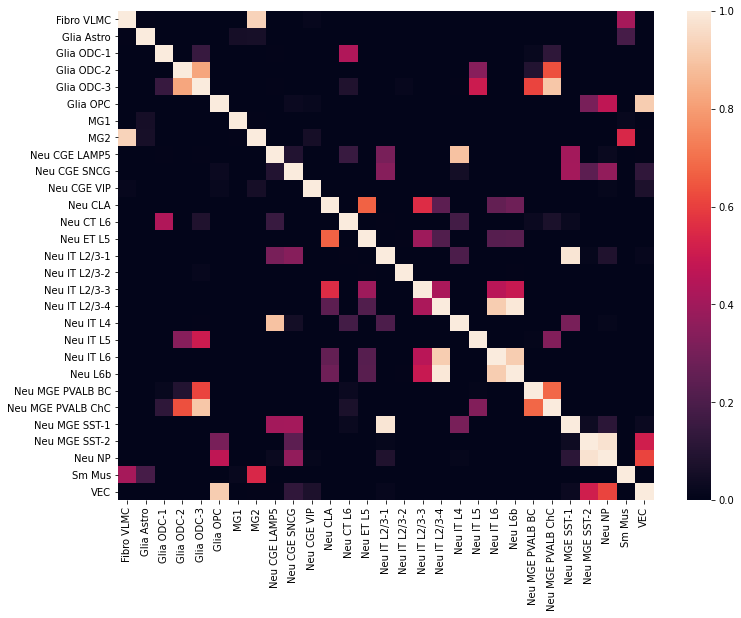

In [113]:
plt.figure(figsize=(12,9))
sns.heatmap(dun_result)

<AxesSubplot:>

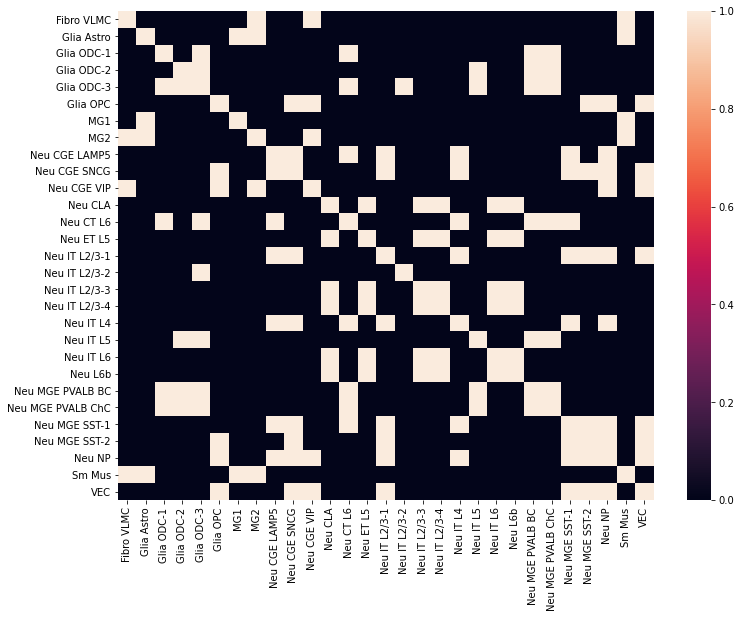

In [114]:
plt.figure(figsize=(12,9))
sns.heatmap(paint)

In [115]:
dun_result.to_csv("dun_APP_BH.csv")

# Construct heatmap

In [13]:
cluster_dmgs['cluster']

names
ENSG00000111679.17                 MG2
ENSG00000100055.21                 MG2
ENSG00000228401.4                  MG2
ENSG00000162511.8                  MG2
ENSG00000125910.5                  MG2
                            ...       
ENSG00000166006.13    Neu MGE PVALB BC
ENSG00000106852.15    Neu MGE PVALB BC
ENSG00000078549.14    Neu MGE PVALB BC
ENSG00000107105.15    Neu MGE PVALB BC
ENSG00000152583.12    Neu MGE PVALB BC
Name: cluster, Length: 1526, dtype: object

In [17]:
tmp1 = gene_frac_da.to_pandas()

In [18]:
tmp1

gene                               ENSG00000227232.5  ENSG00000240361.2  \
cell                                                                      
M1C_presorted_001_Plate1-1-O7-C2            1.000000           1.000000   
M1C_presorted_001_Plate1-1-O7-A1            1.000000           1.000000   
M1C_presorted_001_Plate1-1-O7-E14           1.266019           1.000000   
M1C_presorted_001_Plate1-1-O7-A14           1.000000           1.240790   
M1C_presorted_001_Plate1-1-O7-C1            1.000000           1.000000   
...                                              ...                ...   
M1C_3C_002_Plate8-6-K8-O11                  1.122382           1.000000   
M1C_3C_002_Plate8-6-K8-M11                  1.257917           1.163569   
M1C_3C_002_Plate8-6-K8-O24                  1.116492           1.116492   
M1C_3C_002_Plate8-6-K8-P24                  1.208157           1.213674   
M1C_3C_002_Plate8-6-K8-L24                  1.198803           1.000000   

gene                               ENSG00000186092.6  ENSG00000238009.6  \
cell                                                                      
M1C_presorted_001_Plate1-1-O7-C2            1.000000           1.077319   
M1C_presorted_001_Plate1-1-O7-A1            1.145400           1.199100   
M1C_presorted_001_Plate1-1-O7-E14           1.000000           1.000000   
M1C_presorted_001_Plate1-1-O7-A14           1.000000           1.252914   
M1C_presorted_001_Plate1-1-O7-C1            1.000000           0.785718   
...                                              ...                ...   
M1C_3C_002_Plate8-6-K8-O11                  1.122382           1.145956   
M1C_3C_002_Plate8-6-K8-M11                  1.000000           0.741882   
M1C_3C_002_Plate8-6-K8-O24                  1.000000           1.147640   
M1C_3C_002_Plate8-6-K8-P24                  1.000000           0.960845   
M1C_3C_002_Plate8-6-K8-L24                  1.135356           1.165849   

gene                               ENSG00000233750.3  ENSG00000279928.2  \
cell                                                                      
M1C_presorted_001_Plate1-1-O7-C2            1.000000           1.000000   
M1C_presorted_001_Plate1-1-O7-A1            1.000000           1.000000   
M1C_presorted_001_Plate1-1-O7-E14           1.000000           1.000000   
M1C_presorted_001_Plate1-1-O7-A14           1.240790           1.000000   
M1C_presorted_001_Plate1-1-O7-C1            0.785718           1.000000   
...                                              ...                ...   
M1C_3C_002_Plate8-6-K8-O11                  1.000000           1.000000   
M1C_3C_002_Plate8-6-K8-M11                  1.000000           1.000000   
M1C_3C_002_Plate8-6-K8-O24                  1.208732           1.000000   
M1C_3C_002_Plate8-6-K8-P24                  1.000000           1.144988   
M1C_3C_002_Plate8-6-K8-L24                  1.235617           1.000000   

gene                               ENSG00000279457.4  ENSG00000228463.10  \
cell                                                                       
M1C_presorted_001_Plate1-1-O7-C2            1.258147            1.038668   
M1C_presorted_001_Plate1-1-O7-A1            0.929269            1.000000   
M1C_presorted_001_Plate1-1-O7-E14           1.000000            1.143738   
M1C_presorted_001_Plate1-1-O7-A14           1.240790            1.000000   
M1C_presorted_001_Plate1-1-O7-C1            1.258056            1.000000   
...                                              ...                 ...   
M1C_3C_002_Plate8-6-K8-O11                  0.756663            1.127994   
M1C_3C_002_Plate8-6-K8-M11                  1.000000            1.289738   
M1C_3C_002_Plate8-6-K8-O24                  0.589210            1.208732   
M1C_3C_002_Plate8-6-K8-P24                  0.843653            0.960845   
M1C_3C_002_Plate8-6-K8-L24                  0.638286            0.827053   

gene                               ENSG00000237094.12  ENSG00000230021.10  \
cell  

In [19]:
def gene_id_to_gene_name (gene_id):
    return gene_meta.loc[gene_id, "gene_name"]

In [20]:
columns_list = tmp1.columns
for i in columns_list:
    tmp1.rename(columns = {i: gene_id_to_gene_name (i)}, inplace = True)

In [21]:
tmp1

gene                                 WASH7P   OR4G11P     OR4F5  AL627309.1  \
cell                                                                          
M1C_presorted_001_Plate1-1-O7-C2   1.000000  1.000000  1.000000    1.077319   
M1C_presorted_001_Plate1-1-O7-A1   1.000000  1.000000  1.145400    1.199100   
M1C_presorted_001_Plate1-1-O7-E14  1.266019  1.000000  1.000000    1.000000   
M1C_presorted_001_Plate1-1-O7-A14  1.000000  1.240790  1.000000    1.252914   
M1C_presorted_001_Plate1-1-O7-C1   1.000000  1.000000  1.000000    0.785718   
...                                     ...       ...       ...         ...   
M1C_3C_002_Plate8-6-K8-O11         1.122382  1.000000  1.122382    1.145956   
M1C_3C_002_Plate8-6-K8-M11         1.257917  1.163569  1.000000    0.741882   
M1C_3C_002_Plate8-6-K8-O24         1.116492  1.116492  1.000000    1.147640   
M1C_3C_002_Plate8-6-K8-P24         1.208157  1.213674  1.000000    0.960845   
M1C_3C_002_Plate8-6-K8-L24         1.198803  1.000000  1.135356    1.165849   

gene                                 CICP27  FO538757.1    WASH9P  AP006222.1  \
cell                                                                            
M1C_presorted_001_Plate1-1-O7-C2   1.000000    1.000000  1.258147    1.038668   
M1C_presorted_001_Plate1-1-O7-A1   1.000000    1.000000  0.929269    1.000000   
M1C_presorted_001_Plate1-1-O7-E14  1.000000    1.000000  1.000000    1.143738   
M1C_presorted_001_Plate1-1-O7-A14  1.240790    1.000000  1.240790    1.000000   
M1C_presorted_001_Plate1-1-O7-C1   0.785718    1.000000  1.258056    1.000000   
...                                     ...         ...       ...         ...   
M1C_3C_002_Plate8-6-K8-O11         1.000000    1.000000  0.756663    1.127994   
M1C_3C_002_Plate8-6-K8-M11         1.000000    1.000000  1.000000    1.289738   
M1C_3C_002_Plate8-6-K8-O24         1.208732    1.000000  0.589210    1.208732   
M1C_3C_002_Plate8-6-K8-P24         1.000000    1.144988  0.843653    0.960845   
M1C_3C_002_Plate8-6-K8-L24         1.235617    1.000000  0.638286    0.827053   

gene                               AL732372.2  AL669831.3  ...     SYCE3  \
cell                                                       ...             
M1C_presorted_001_Plate1-1-O7-C2     1.000000    0.752751  ...  0.720675   
M1C_presorted_001_Plate1-1-O7-A1     1.199100    0.597750  ...  0.189785   
M1C_presorted_001_Plate1-1-O7-E14    0.789659    0.736049  ...  1.112193   
M1C_presorted_001_Plate1-1-O7-A14    1.000000    1.218429  ...  1.284127   
M1C_presorted_001_Plate1-1-O7-C1     1.000000    0.424855  ...  1.264430   
...                                       ...         ...  ...       ...   
M1C_3C_002_Plate8-6-K8-O11           1.122382    1.067482  ...  1.105856   
M1C_3C_002_Plate8-6-K8-M11           1.000000    0.922615  ...  0.948285   
M1C_3C_002_Plate8-6-K8-O24           1.000000    0.973223  ...  1.257227   
M1C_3C_002_Plate8-6-K8-P24           1.144988    0.871284  ...  1.199690   
M1C_3C_002_Plate8-6-K8-L24           1.198803    0.997255  ...  1.339017   

gene                               CHKB-CPT1B      CHKB  MAPK8IP2      ARSA  \
cell                                                                          
M1C_presorted_001_Plate1-1-O7-C2     1.157118  1.000000  0.489202  0.613304   
M1C_presorted_001_Plate1-1-O7-A1     1.145400  0.446932  0.668077  1.000000   
M1C_presorted_001_Plate1-1-O7-E14    1.000000  0.414185  0.592054  0.602986   
M1C_presorted_001_Plate1-1-O7-A14    0.480953  0.293671  0.152642  0.530744   
M1C_presorted_001_Plate1-1-O7-C1     0.780430  1.076504  0.665928  0.166148   
...                                       ...       ...       ...       ...   
M1C_3C_002_Plate8-6-K8-O11           1.145956  0.374929  0.803287  0.642050   
M1C_3C_002_Plate8-6-K8-M11           1.140699  0.734175  1.124340  1.306626   
M1C_3C_002_Plate8-6-K8-O24           0.973646  0.554847  0.592233  0.575135   
M1C_3C_002_Plate8-6-K8-P24           0.904748  0.576967  1.2

In [31]:
index_list = tmp1.index
for i in index_list:
    tmp1.rename(index = {i: mcad.obs.loc[i, 'celltype']}, inplace = True)

In [32]:
tmp1

gene                WASH7P   OR4G11P     OR4F5  AL627309.1    CICP27  \
cell                                                                   
Neu CT L6         1.000000  1.000000  1.000000    1.077319  1.000000   
Glia Astro        1.000000  1.000000  1.145400    1.199100  1.000000   
Neu IT L2/3-1     1.266019  1.000000  1.000000    1.000000  1.000000   
Neu IT L2/3-2     1.000000  1.240790  1.000000    1.252914  1.240790   
Neu IT L4         1.000000  1.000000  1.000000    0.785718  0.785718   
...                    ...       ...       ...         ...       ...   
Glia Astro        1.122382  1.000000  1.122382    1.145956  1.000000   
Glia Astro        1.257917  1.163569  1.000000    0.741882  1.000000   
Neu MGE PVALB BC  1.116492  1.116492  1.000000    1.147640  1.208732   
Glia OPC          1.208157  1.213674  1.000000    0.960845  1.000000   
Glia ODC-2        1.198803  1.000000  1.135356    1.165849  1.235617   

gene              FO538757.1    WASH9P  AP006222.1  AL732372.2  AL669831.3  \
cell                                                                         
Neu CT L6           1.000000  1.258147    1.038668    1.000000    0.752751   
Glia Astro          1.000000  0.929269    1.000000    1.199100    0.597750   
Neu IT L2/3-1       1.000000  1.000000    1.143738    0.789659    0.736049   
Neu IT L2/3-2       1.000000  1.240790    1.000000    1.000000    1.218429   
Neu IT L4           1.000000  1.258056    1.000000    1.000000    0.424855   
...                      ...       ...         ...         ...         ...   
Glia Astro          1.000000  0.756663    1.127994    1.122382    1.067482   
Glia Astro          1.000000  1.000000    1.289738    1.000000    0.922615   
Neu MGE PVALB BC    1.000000  0.589210    1.208732    1.000000    0.973223   
Glia OPC            1.144988  0.843653    0.960845    1.144988    0.871284   
Glia ODC-2          1.000000  0.638286    0.827053    1.198803    0.997255   

gene              ...     SYCE3  CHKB-CPT1B      CHKB  MAPK8IP2      ARSA  \
cell              ...                                                       
Neu CT L6         ...  0.720675    1.157118  1.000000  0.489202  0.613304   
Glia Astro        ...  0.189785    1.145400  0.446932  0.668077  1.000000   
Neu IT L2/3-1     ...  1.112193    1.000000  0.414185  0.592054  0.602986   
Neu IT L2/3-2     ...  1.284127    0.480953  0.293671  0.152642  0.530744   
Neu IT L4         ...  1.264430    0.780430  1.076504  0.665928  0.166148   
...               ...       ...         ...       ...       ...       ...   
Glia Astro        ...  1.105856    1.145956  0.374929  0.803287  0.642050   
Glia Astro        ...  0.948285    1.140699  0.734175  1.124340  1.306626   
Neu MGE PVALB BC  ...  1.257227    0.973646  0.554847  0.592233  0.575135   
Glia OPC          ...  1.199690    0.904748  0.576967  1.257813  0.621198   
Glia ODC-2        ...  1.339017    0.745486  0.594952  0.758642  0.322920   

gene                SHANK3  AC000036.1       ACR  AC002056.1  RPL23AP82  
cell                                                                     
Neu CT L6         0.859642    1.000000  1.157118    1.000000   0.113612  
Glia Astro        1.088534    1.000000  1.000000    1.000000   1.145400  
Neu IT L2/3-1     0.785557    1.000000  1.266019    1.000000   1.091126  
Neu IT L2/3-2     0.895118    1.000000  0.557712    1.000000   1.294829  
Neu IT L4         0.775037    1.000000  1.192941    1.000000   1.226923  
...                    ...         ...       ...         ...        ...  
Glia Astro        0.995903    1.259127  1.185092    1.000000   0.348250  
Glia Astro        0.814689    0.932157  1.260650    1.188170   1.248827  
Neu MGE PVALB BC  0.837549    1.208732  1.113003    0.612925   0.884147  
Glia OPC          1.148858    1.000000  1.208157    1.000000   0.353249  
Glia ODC-2        0.904221    1.000000  1.329484    1.000000   0.957597  

[8225 rows x 31199 columns]

In [40]:
grouped_df = tmp1.groupby("cell")
mean_df = grouped_df.mean()
mean_df = mean_df.reset_index()
paint = mean_df.set_index("cell")

In [41]:
paint

gene                 WASH7P   OR4G11P     OR4F5  AL627309.1    CICP27  \
cell                                                                    
Fibro VLMC         1.097023  1.055793  1.004645    1.037731  1.056639   
Glia Astro         1.065832  1.055079  1.012845    1.015483  1.043985   
Glia ODC-1         1.073164  1.057145  1.013565    0.996946  1.050476   
Glia ODC-2         1.067051  1.062631  1.013986    1.023083  1.055979   
Glia ODC-3         1.031742  1.019359  0.986498    1.052966  1.020448   
Glia OPC           1.019470  1.066209  1.017447    1.003444  1.041779   
MG1                1.096022  1.053815  1.010203    0.988030  1.061284   
MG2                1.059847  1.070989  1.023306    1.045764  1.027769   
Neu CGE LAMP5      1.048847  1.049096  1.004904    1.052293  1.037948   
Neu CGE SNCG       1.071138  1.031540  1.012799    1.028383  1.049736   
Neu CGE VIP        1.048170  1.049940  1.010874    1.045081  1.036971   
Neu CLA            1.067333  1.054963  1.016307    1.103188  1.035264   
Neu CT L6          1.054353  1.048671  1.020162    1.077514  1.051619   
Neu ET L5          1.014588  1.062324  1.017306    1.118999  1.063790   
Neu IT L2/3-1      1.078631  1.056522  1.011928    1.079634  1.050263   
Neu IT L2/3-2      1.083413  1.066444  1.021379    1.100011  1.055708   
Neu IT L2/3-3      1.092407  1.069270  1.018823    1.092419  1.054114   
Neu IT L2/3-4      1.063788  1.057971  1.018038    1.075517  1.051418   
Neu IT L4          1.048153  1.055606  1.019881    1.081232  1.046345   
Neu IT L5          1.043978  1.052663  1.012491    1.103597  1.055092   
Neu IT L6          1.065506  1.063756  1.023841    1.092353  1.053117   
Neu L6b            1.050666  1.065724  1.008743    1.090717  1.061194   
Neu MGE PVALB BC   1.056733  1.046634  1.009449    1.069436  1.035824   
Neu MGE PVALB ChC  1.081491  1.053179  1.023172    1.033814  1.043115   
Neu MGE SST-1      1.049500  1.018151  1.013570    1.032819  1.034730   
Neu MGE SST-2      1.046132  1.054025  1.009133    1.051313  1.037328   
Neu NP             1.049566  1.049401  1.010711    1.066348  1.050479   
Sm Mus             1.047837  1.067844  1.006389    1.034313  1.052743   
VEC                1.083709  1.070798  1.024284    0.991910  1.052004   

gene               FO538757.1    WASH9P  AP006222.1  AL732372.2  AL669831.3  \
cell                                                                          
Fibro VLMC           1.045160  1.096988    1.036211    1.028887    0.876072   
Glia Astro           1.051283  0.979959    1.035293    1.033583    0.885086   
Glia ODC-1           1.066272  0.957861    1.003178    1.037827    0.867510   
Glia ODC-2           1.067526  0.943972    0.995141    1.036754    0.851415   
Glia ODC-3           1.012134  0.966974    1.021474    1.002776    0.886911   
Glia OPC             1.067388  0.932230    1.059299    1.056386    0.909642   
MG1                  1.077616  1.150003    1.033736    1.033142    0.914000   
MG2                  1.040146  1.101297    1.051264    1.042409    0.950207   
Neu CGE LAMP5        1.056650  1.043473    1.046988    1.047794    0.843943   
Neu CGE SNCG         1.053671  0.976199    1.056180    1.032004    0.850979   
Neu CGE VIP          1.045054  0.964613    1.064077    1.031455    0.870983   
Neu CLA              1.052524  1.141469    1.085792    1.064045    0.911468   
Neu CT L6            1.055702  1.146953    1.117384    1.034840    0.893698   
Neu ET L5            1.057972  1.161834    1.093861    1.051174    0.862020   
Neu IT L2/3-1        1.049931  1.134887    1.067056    1.046013    0.894969   
Neu IT L2/3-2        1.067083  1.152197    1.094647    1.044966    0.912365   
Neu IT L2/3-3        1.072432  1.143650    1.072444    1.040947    0.907493   
Neu IT L2/3-4        1.057204  1.144523    1.093518    1.046648    0.898741   
Neu IT L4            1.061377  1.137780    1.088418    1.033025    0.903968   
Neu IT L5            1.063351  1.140329    1.115894    1.033951    0.903013  

In [43]:
paint.to_csv(f'{indir}mcfrac_celltype.csv')

In [44]:
tmp2 = paint.T

In [45]:
tmp2

cell        Fibro VLMC  Glia Astro  Glia ODC-1  Glia ODC-2  Glia ODC-3  \
gene                                                                     
WASH7P        1.097023    1.065832    1.073164    1.067051    1.031742   
OR4G11P       1.055793    1.055079    1.057145    1.062631    1.019359   
OR4F5         1.004645    1.012845    1.013565    1.013986    0.986498   
AL627309.1    1.037731    1.015483    0.996946    1.023083    1.052966   
CICP27        1.056639    1.043985    1.050476    1.055979    1.020448   
...                ...         ...         ...         ...         ...   
SHANK3        0.909135    0.928981    0.838938    0.883402    0.844864   
AC000036.1    1.100305    1.122212    1.143116    1.132330    1.064336   
ACR           1.132764    1.167150    1.187889    1.166083    1.119207   
AC002056.1    1.053771    1.038854    1.009864    1.008909    0.989692   
RPL23AP82     0.950966    0.978047    0.968568    0.978809    1.001538   

cell        Glia OPC       MG1       MG2  Neu CGE LAMP5  Neu CGE SNCG  ...  \
gene                                                                   ...   
WASH7P      1.019470  1.096022  1.059847       1.048847      1.071138  ...   
OR4G11P     1.066209  1.053815  1.070989       1.049096      1.031540  ...   
OR4F5       1.017447  1.010203  1.023306       1.004904      1.012799  ...   
AL627309.1  1.003444  0.988030  1.045764       1.052293      1.028383  ...   
CICP27      1.041779  1.061284  1.027769       1.037948      1.049736  ...   
...              ...       ...       ...            ...           ...  ...   
SHANK3      0.763982  1.154267  1.141752       0.960609      0.957624  ...   
AC000036.1  1.114806  1.117501  1.071833       1.111254      1.085875  ...   
ACR         1.188331  1.170810  1.203159       1.158412      1.161484  ...   
AC002056.1  1.034582  1.004631  1.035530       1.010813      1.015255  ...   
RPL23AP82   0.948218  1.009861  1.039578       0.966203      0.983800  ...   

cell        Neu IT L5  Neu IT L6   Neu L6b  Neu MGE PVALB BC  \
gene                                                           
WASH7P       1.043978   1.065506  1.050666          1.056733   
OR4G11P      1.052663   1.063756  1.065724          1.046634   
OR4F5        1.012491   1.023841  1.008743          1.009449   
AL627309.1   1.103597   1.092353  1.090717          1.069436   
CICP27       1.055092   1.053117  1.061194          1.035824   
...               ...        ...       ...               ...   
SHANK3       0.884199   0.788172  0.869772          0.926396   
AC000036.1   1.100278   1.121446  1.122291          1.086841   
ACR          1.165729   1.195463  1.207200          1.112798   
AC002056.1   1.037122   1.037171  1.028007          1.022735   
RPL23AP82    0.978302   1.005423  0.963513          0.976814   

cell        Neu MGE PVALB ChC  Neu MGE SST-1  Neu MGE SST-2    Neu NP  \
gene                                                                    
WASH7P               1.081491       1.049500       1.046132  1.049566   
OR4G11P              1.053179       1.018151       1.054025  1.049401   
OR4F5                1.023172       1.013570       1.009133  1.010711   
AL627309.1           1.033814       1.032819       1.051313  1.066348   
CICP27               1.043115       1.034730       1.037328  1.050479   
...                       ...            ...            ...       ...   
SHANK3               0.930214       0.946343       0.941694  0.912938   
AC000036.1           1.116085       1.072105       1.091863  1.100673   
ACR                  1.058536       1.147861       1.165376  1.043688   
AC002056.1           1.029999       1.023463       1.023286  1.036641   
RPL23AP82            1.013818       1.011068       1.013269  0.933766   

cell          Sm Mus       VEC  
gene                            
WASH7P      1.047837  1.083709  
OR4G11P     1.067844  1.070798  
OR4F5       1.006389  1.024284  
AL627309.1  1.034313  0.991910  
CICP27      1.052743  1.052004  
...     

In [47]:
celltype_list = mcad.obs["celltype"].unique()

In [49]:
keep = []

for i in celltype_list:
    tmp = tmp2.nlargest(10, [i]).index
    for j in tmp:
        keep.append(j)

In [51]:
paint_top10 = paint.loc[:, keep]

In [52]:
paint_top10

gene               AC104117.3  AL158212.5  AC079612.1  C13orf46      NPR2  \
cell                                                                        
Fibro VLMC           1.291362    1.185265    1.255632  1.241692  1.202387   
Glia Astro           1.261680    1.146460    1.229825  1.209039  1.207232   
Glia ODC-1           1.291375    1.242925    1.277604  1.266421  1.242211   
Glia ODC-2           1.283498    1.270478    1.264423  1.264390  1.262653   
Glia ODC-3           1.231773    1.143402    1.179948  1.223633  1.202827   
Glia OPC             1.277551    1.129700    1.251325  1.244129  1.195392   
MG1                  1.286050    1.220801    1.213233  1.319513  1.292743   
MG2                  1.231071    1.185046    1.199137  1.264232  1.250464   
Neu CGE LAMP5        1.209789    1.148123    1.204633  1.209833  1.185447   
Neu CGE SNCG         1.200609    1.178334    1.189174  1.210336  1.192742   
Neu CGE VIP          1.189350    1.206892    1.185013  1.201165  1.176037   
Neu CLA              1.252768    1.184330    1.223336  1.233753  1.206207   
Neu CT L6            1.258407    1.230524    1.240839  1.252429  1.170177   
Neu ET L5            1.244518    1.227028    1.191516  1.263363  1.206273   
Neu IT L2/3-1        1.265699    1.185433    1.234055  1.241370  1.171769   
Neu IT L2/3-2        1.263614    1.194872    1.238398  1.266297  1.179297   
Neu IT L2/3-3        1.250590    1.204442    1.236920  1.270434  1.193776   
Neu IT L2/3-4        1.252380    1.198347    1.198385  1.244710  1.211420   
Neu IT L4            1.251585    1.231566    1.229055  1.245832  1.188021   
Neu IT L5            1.217751    1.214027    1.212974  1.234720  1.197758   
Neu IT L6            1.258894    1.221659    1.236329  1.260822  1.199161   
Neu L6b              1.258673    1.190781    1.230905  1.243687  1.185106   
Neu MGE PVALB BC     1.197425    1.196012    1.190794  1.201438  1.172782   
Neu MGE PVALB ChC    1.200299    1.181501    1.191866  1.199550  1.154871   
Neu MGE SST-1        1.201466    1.185715    1.186202  1.205516  1.179618   
Neu MGE SST-2        1.183014    1.182732    1.177757  1.190581  1.169352   
Neu NP               1.197199    1.151646    1.199684  1.197881  1.161189   
Sm Mus               1.328023    1.182694    1.250258  1.292752  1.284838   
VEC                  1.280487    1.238463    1.238141  1.228477  1.251518   

gene               LINC02257    ZNF124  AC011747.1      RBP3   SLC22A1  ...  \
cell                                                                    ...   
Fibro VLMC          1.195171  1.239070    1.241952  1.263160  1.201472  ...   
Glia Astro          1.233568  1.235609    1.259899  1.258378  1.243113  ...   
Glia ODC-1          1.257731  1.254055    1.273673  1.281224  1.270640  ...   
Glia ODC-2          1.262052  1.261679    1.259940  1.259643  1.259472  ...   
Glia ODC-3          1.213254  1.202536    1.216330  1.208278  1.202575  ...   
Glia OPC            1.252649  1.244675    1.257799  1.268533  1.239652  ...   
MG1                 1.181181  1.284413    1.242397  1.178169  1.103013  ...   
MG2                 1.219848  1.243324    1.200041  1.228619  1.119286  ...   
Neu CGE LAMP5       1.218291  1.169779    1.206845  1.224207  1.200801  ...   
Neu CGE SNCG        1.214438  1.184715    1.202398  1.210817  1.199656  ...   
Neu CGE VIP         1.193330  1.178376    1.194184  1.184767  1.188612  ...   
Neu CLA             1.252319  1.203141    1.128129  1.250342  1.225377  ...   
Neu CT L6           1.251825  1.173533    1.141092  1.252602  1.253034  ...   
Neu ET L5           1.243697  1.191581    1.233185  1.257767  1.225433  ...   
Neu IT L2/3-1       1.264283  1.222764    1.229512  1.266376  1.249913  ...   
Neu IT L2/3-2       1.258769  1.218126    1.172999  1.262452  1.260320  ...   
Neu IT L2/3-3       1.263084  1.222573    1.203967  1.282223  1.256601  ...   
Neu IT L2/3-4       1.251917  1.192143    1.181819  1.259102  1.246104  ...   
Neu IT L4           1.242103  1.

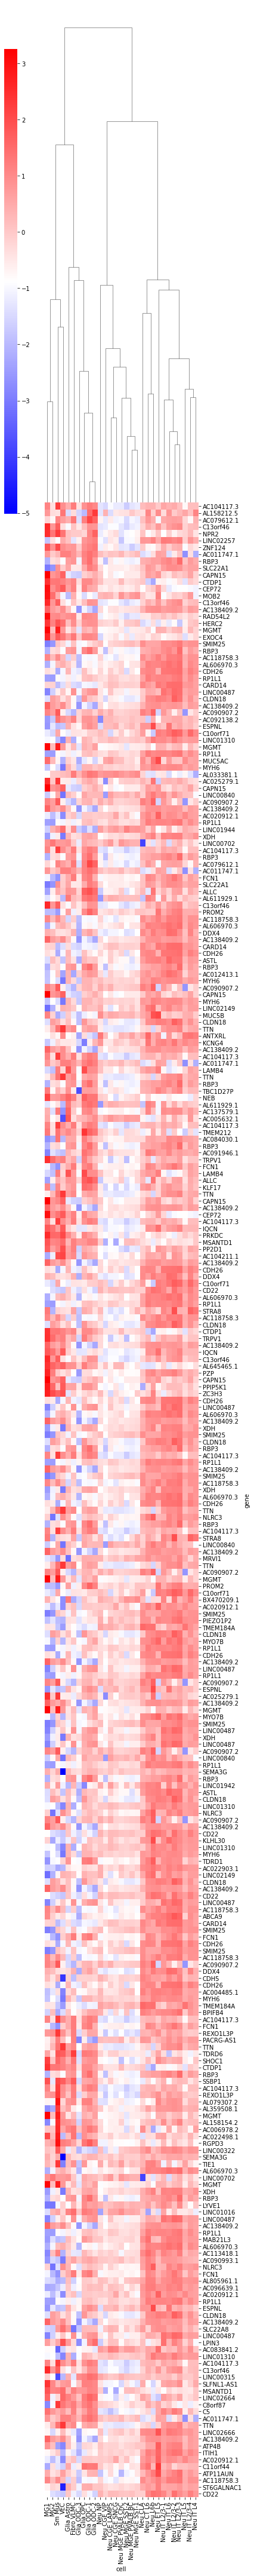

In [55]:
cg = sns.clustermap(paint_top10.T, figsize=(6,60), z_score=0, method='average', metric='correlation', cmap='bwr', row_cluster=False, xticklabels=True, yticklabels=True)

# Differential Methylated Genes - Pairwise

In [25]:
adj_p_cutoff = 1e-3
delta_rate_cutoff = 0.3
auroc_cutoff = 0.9
random_state = 0
n_jobs = 30

In [26]:
cell_meta = mcad.obs.copy()
cell_meta.index.name = obs_dim

gene_meta = pd.read_csv(f'{indir}GeneMetadata.csv.gz', index_col=0)

gene_mcds = MCDS.open(gf_mcds_path, use_obs=cell_meta.index)
gene_mcds

<xarray.MCDS>
Dimensions:        (cell: 8225, gene: 36443, mc_type: 2)
Coordinates:
  * cell           (cell) <U34 'M1C_presorted_001_Plate1-1-O7-C2' ... 'M1C_3C...
  * gene           (gene) <U18 'ENSG00000223972.5' ... 'ENSG00000184319.16'
    gene_chrom     (gene) <U5 dask.array<chunksize=(4096,), meta=np.ndarray>
    gene_cov_mean  (gene) float64 dask.array<chunksize=(4096,), meta=np.ndarray>
    gene_end       (gene) int64 dask.array<chunksize=(4096,), meta=np.ndarray>
    gene_start     (gene) int64 dask.array<chunksize=(4096,), meta=np.ndarray>
  * mc_type        (mc_type) <U3 'CGN' 'CHN'
    strand_type    <U4 'both'
Data variables:
    gene_da_frac   (cell, gene, mc_type) float32 dask.array<chunksize=(1645, 4096, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  gene

In [40]:
cell_meta[cluster_col] = cell_meta[cluster_col].str.replace(' ','_')
cell_meta[cluster_col] = cell_meta[cluster_col].str.replace('/','_')

In [41]:
cell_meta[cluster_col]

cell
M1C_3C_001_Plate1-1-F3-A2               Glia_ODC-2
M1C_3C_001_Plate1-1-F3-B1               Glia_ODC-2
M1C_3C_001_Plate1-1-F3-B13                     MG1
M1C_3C_001_Plate1-1-F3-B14           Neu_IT_L2.3-3
M1C_3C_001_Plate1-1-F3-B2            Neu_IT_L2.3-3
                                         ...      
M1C_presorted_002_Plate8-6-K3-O24      Neu_CGE_VIP
M1C_presorted_002_Plate8-6-K3-P11    Neu_IT_L2.3-1
M1C_presorted_002_Plate8-6-K3-P12    Neu_IT_L2.3-2
M1C_presorted_002_Plate8-6-K3-P23    Neu_IT_L2.3-1
M1C_presorted_002_Plate8-6-K3-P24        Neu_IT_L6
Name: celltype, Length: 8225, dtype: object

In [42]:
pwdmg = PairwiseDMG(max_cell_per_group=1000,
                    top_n=top_n,
                    adj_p_cutoff=adj_p_cutoff,
                    delta_rate_cutoff=delta_rate_cutoff,
                    auroc_cutoff=auroc_cutoff,
                    random_state=random_state,
                    n_jobs=n_jobs)

In [ ]:
pwdmg.fit_predict(x=gene_mcds[f'{var_dim}_da_frac'].sel(mc_type=mc_type), 
                  var_dim=var_dim,
                  groups=cell_meta[cluster_col])

Generating cluster AnnData files
Computing pairwise DMG
406 pairwise DMGs
1/406 finished


In [ ]:
pwdmg.dmg_table.to_hdf(f'{indir + cluster_col}.PairwiseDMG.{mc_type}.hdf', key='data')
pwdmg.dmg_table.head()

In [ ]:
cluster_dmgs = pwdmg.aggregate_pairwise_dmg(mcad, groupby=cluster_col)

In [ ]:
# save all the DMGs
with pd.HDFStore(f'{indir + cluster_col}.ClusterRankedPWDMG.{mc_type}.hdf') as hdf:
    for cluster, dmgs in cluster_dmgs.items():
        hdf[cluster] = dmgs[dmgs > 0.0001]